# ***프로젝트 개요***

## 0과 1을 분류하는 인공신경망

인공 신경망을 미리 구현된 딥러닝용 라이브러리를 사용하지 않고 구현한다.

사용 가능한 라이브러리:
- Numpy
- Pandas
- Csv
- Matplotlib
- 이외 파이썬 기본 내장 라이브러리

# ***프로젝트 절차***

## Deep Learning workflow

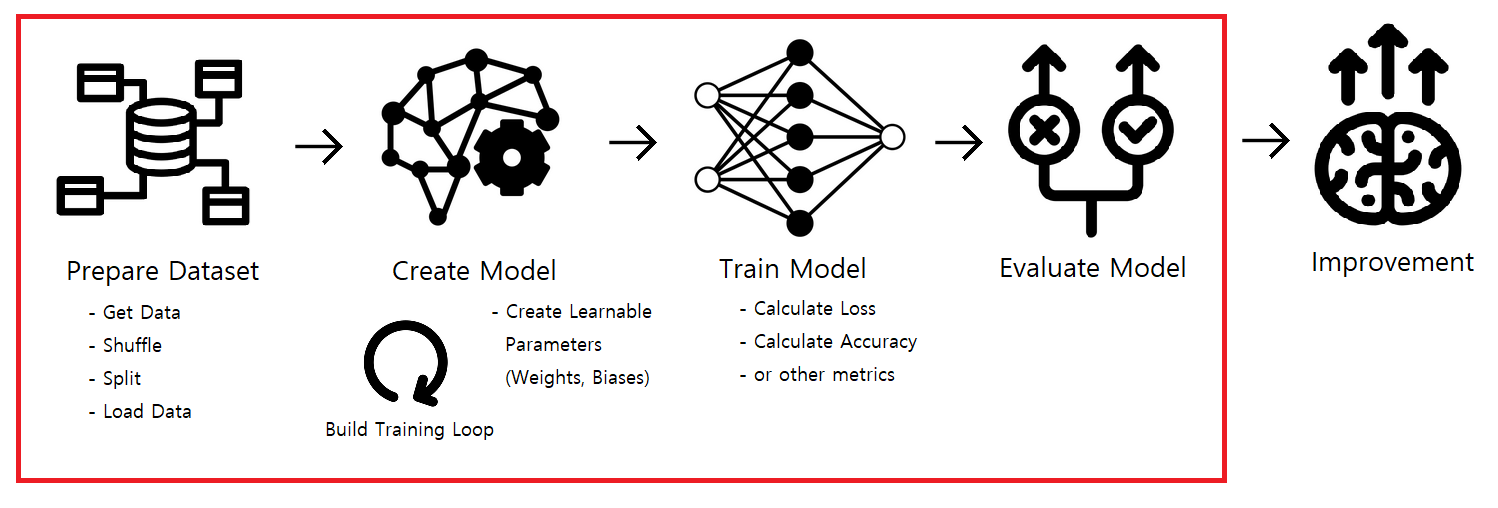

딥러닝 모델을 구현하는 과정을 간단하게 표현하면 위 그림으로 나타낼 수 있다.  
문제를 해결하기 위한 **데이터셋을 구하는 것** 부터 시작해서 *데이터셋에 맞는 (data specific inductive bias)* **모델을 만드는 것**, 그 데이터들로 만든 **모델을 훈련** 시킨다. 훈련시키면서 설정해둔 **평가 지표를 확인**하고, 모델이 학습이 잘 되가는지, 원하는 결과를 잘 출력해주는지 확인해준다. 좀 더 개선이 필요하다면 모델 구조를 변경하거나 데이터를 더 구하거나 (이미지의 경우 Augmentation) 등의 추가적인 작업들을 진행해준다. 원하는 수준의 모델 결과가 나올 때 까지 이 과정을 반복해준다.  
이 노트에서는 모델을 평가하는 것까지만 진행한다. 그리고 각 진행사항은 재사용을 위해 함수나 클래스로 만들어준다.

1. 데이터셋 준비
    - 데이터를 받오는 함수 정의
    - 데이터를 미니배치씩 반복해서 불러주는 클래스 정의
    - 훈련 및 테스트 데이터로 분리하는 함수 정의
    - 데이터 표준화 클래스 정의

2. 모델 생성
    - 모델에 필요한 클래스들 생성
        - 선형 층(Linear layer), 활성화 함수(ReLU, Sigmoid), 손실함수(Binary Cross Entropy), 평가 함수(Accuracy), 옵티마이저(Stochastic Gradient Descent)
    - 훈련 루프 정의

3. 모델 훈련 및 평가
    - 위에 생성한 모델 및 훈련 루프로 모델 학습
    - 테스트 데이터로 모델 평가

4. 하나로 합치기
    - 위에 정의한 함수와 클래스들을 하나의 함수로 실행할 수 있도록 정의

5. Appendix  
    a. 모델에 사용한 함수들의 역전파  
    b. 모듈화

# ***프로젝트 결과***

## Import libraries

In [1]:
import os
import requests
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Prepare Dataset

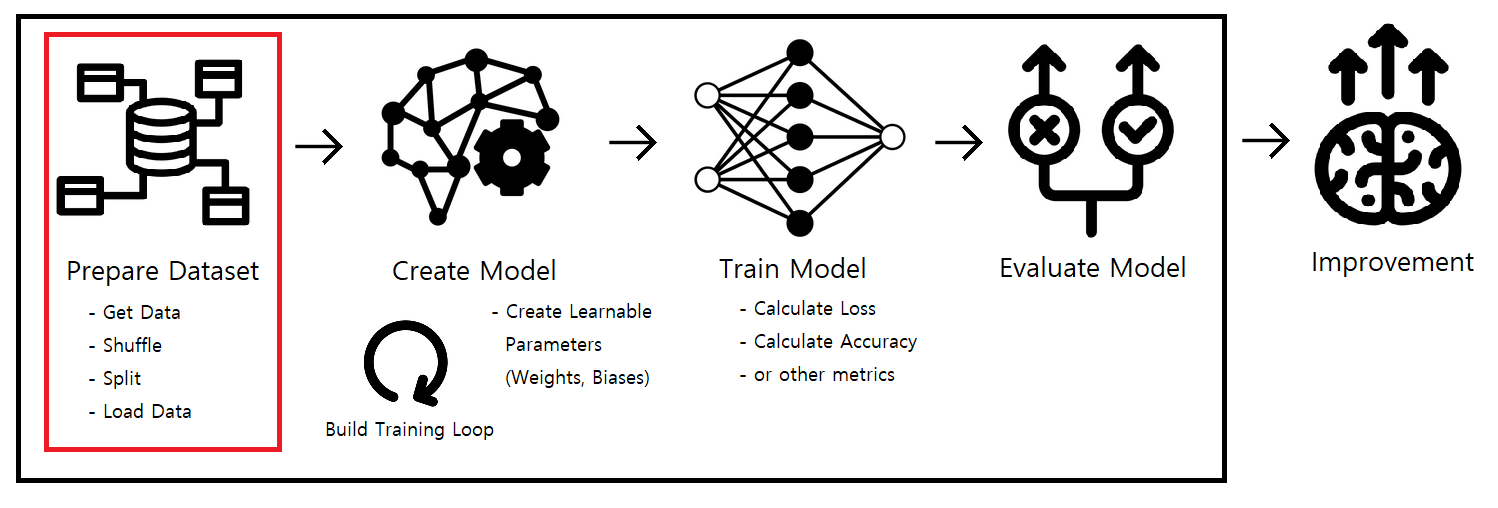

주어진 과제는 "***순전파 연산이 어떻게 이루어지는지***"를 보여주는 것을 목표로 하므로 간단한 이진 분류 데이터셋을 사용한다. 사용하는 데이터셋은 csv 파일로 되어있어 `Pandas`를 통해 데이터프레임으로 불러와 확인해준다.

### 1.1 Download Dataset
주어진 데이터셋을 불러와 데이터 디렉토리 ('data/')에 저장해준다.  
이미 데이터가 데이터 디렉토리에 있다면 바로 판다스를 이용해 데이터프레임을 불러오고 그렇지 않다면 requests를 이용해 받아온다.

In [2]:
def download_data():
    """Download 'binary_dataset.csv' if this file not in data directory.
    If already have one, then skip downloading.
    This csv file contains 8 float type features 
    and one binary target at last column.

    Return
        df (pandas.DataFrame): DataFrame with 9 columns. 
            First 8 columns (x1 ~ x8) are feature columns with float type.
            Last 1 column (y) is target column with binary type (0 or 1)
    """
    # 데이터 저장용 data 디렉토리 생용
    data_path = Path('data/')
    if not data_path.is_dir():
        data_path.mkdir(parents=True, exist_ok=True)

    try: # 데이터셋이 현재 위치에 있다면 판다스로 불러오기
        df = pd.read_csv(data_path / 'binary_dataset.csv') 
        # print("[INFO] 'binary_dataset.csv' already in directory. "
        #       "Get DataFrame from 'data/'")
    except: # 데이터셋이 현재 위치에 없다면
        # requests로 url에서 데이터를 가져온 후에 판다스로 불러온다.
        with open(data_path / "binary_dataset.csv", "wb") as f: 
            request = requests.get("https://drive.google.com/uc?export=download&id=1SCO0ZGL_EDGWc9Le0JFDw9eww86xk1xJ")
            # print("[INFO] No 'binary_dataset.csv' found in current directory. "
            #       "Downloading dataset...")
            f.write(request.content)
            # print("[INFO] Download Done!")
        # !wget "https://drive.google.com/uc?export=download&id=1SCO0ZGL_EDGWc9Le0JFDw9eww86xk1xJ" -O "binary_dataset.csv"
        # !mv binary_dataset.csv {data_path}
        df = pd.read_csv(data_path / 'binary_dataset.csv')
    return df

In [3]:
binary_df = download_data()

In [4]:
print(f'Binary Dataset has {binary_df.shape[0]} rows and {binary_df.shape[1]} columns')
print("Binary Dataset looks like:\n")
binary_df.head()

Binary Dataset has 20 rows and 9 columns
Binary Dataset looks like:



,x1,x2,x3,x4,x5,x6,x7,x8,y
0,136.093750,51.691005,-0.045909,-0.271816,9.342809,38.096400,4.345438,18.673649,0
1,99.367188,41.572202,1.547197,4.154106,27.555184,61.719016,2.208808,3.662680,1
2,100.890625,51.890394,0.627487,-0.026498,3.883779,23.045267,6.953168,52.279440,0
3,120.554688,45.549905,0.282924,0.419909,1.358696,13.079034,13.312141,212.597029,1
4,121.882812,53.042675,0.200521,-0.282219,2.116221,16.580876,8.947603,91.011762,0


### 1.2 DataLoader

#### Data Split
모델 학습을 위한 데이터는 훈련용과 테스트용으로 나눈다. 훈련용 데이터는 말 그대로 모델의 학습 가능한 파라미터들 (가중치, 편향)을 목적에 맞게 학습시키는데 사용한다. 테스트 데이터는 학습한 모델의 일반화 성능을 알아보는데 사용한다. 모두 훈련에 사용을 한다면 가지고 있는 데이터가 가능한 모든 경우의 데이터일 수 없기 때문에 현재 가지고 있는 데이터만 잘 맞추는 (과적합) 문제가 발생한다. 때문에 훈련 과정에서 보지 못한 데이터를 입력 해서 얼마나 잘 예측하는지 확인하기 위해 테스트 세트를 나눠준다.  
이 때 모델의 구조를 변경하거나(튜닝) 다른 작업으로 모델의 성능을 더 끌어올릴 수 있는지 확인하기 위해 검증 세트로 한 번 더 나눠주기도 한다. 테스트 데이터처럼 학습에 사용되지 않는다(모델 파라미터를 수정하기 위한 역전파 과정이 없다).  
통상적으로 *훈련 데이터는 전체 데이터의 60\~80%*를 사용하며, *테스트 데이터는 10\~20%*, *검증용 데이터는 사용한다면 10\~20%*를 사용한다.

지금은 데이터를 훈련용 80%, 테스트용 20%로 나눠준다. 나누는 방법은 전체 데이터 길이(row 수)의 80%에 해당하는 인덱스를 가져와 슬라이싱으로 나눠준다.

```python
train_split = int(0.8 * len(data)) # 80%에 해당하는 인덱스

train_data = data[:train_split] # 해당 인덱스 이전 데이터들은 훈련 데이터로
test_data = data[train_split:] # 이후 데이터들은 테스트 데이터로
```

#### Data Shuffle

데이터를 나눠줄 때 데이터를 적절히 섞어주는 과정도 필요하다. 특정 데이터가 섞이지 않아 순차적으로 되어있다면 모델이 그 순서까지 학습해버리거나 극단적인 경우 특정 타겟 값(클래스)가 훈련 또는 테스트 데이터셋에만 있는 경우가 발생할 수도 있기 때문이다. 이는 일반화 성능에 좋지 않은 영향을 주며 모델 학습도 부정확하게 될 수 있다. Numpy를 사용할 경우 `numpy.random.shuffle` 또는 `numpy.random.permutation`를 사용하면 되고 Pandas를 사용할 경우 `pandas.DataFrame.sample`에서 `frac=1`을 파라미터로 넘겨주면 된다.

```python
# Numpy
np.random.shuffle(data) # 기존 데이터 순서 변경
data_shuffled = np.random.permutation(data) # 기존 데이터 유지한 채로 순서를 섞은 배열 반환

# Pandas
data_shuffled = data.sample(frac=1)
```

#### Data Load

모델에 데이터를 학습시킬 때 모든 훈련데이터를 한번에 학습 시킨다면 연산 결과를 저장해두기 위해 많은 메모리가 필요하게 되고, 모델 파라미터들의 업데이트가 한번밖에 진행되지 않기 때문에 정확한 파라미터를 찾이 않았을 수도 있다. 반면에 훈련 데이터를 하나씩 가져와서 학습을 시킨다면 잦은 업데이트로 더 정확한 답을 찾을 수도 있겠지만 훈련과정이 오래걸리게 되고 데이터 하나마다 파라미터를 업데이트 하기 때문에 노이즈에 민감하게 반응하게 된다.  
그래서 모델을 훈련할 때는 이 둘의 장점을 가져와 미니배치로 데이터를 나누어 훈련하게 된다. 미니배치로 훈련을 진행한다면 각 미니배치마다 모델 파라미터를 업데이트 하게 되고, 여러 데이터를 같이 보기 때문에 노이즈에도 덜 민감해진다. 예를 들어 100개의 데이터를 미니배치 20으로 두고 모델을 훈련한다면 총 5번을 반복하고 5번 모델 파라미터가 업데이트 된다. 이렇게 모든 훈련 데이터를 사용해 학습 했을 때 1 에포크가 완료되었다고 한다.


#### Data Scaling

학습에 사용되는 데이터의 크기가 특성마다 매우 다른 경우가 있다. 이 경우에는 모델의 학습을 어렵게 만들 수도 있다. 예를들어 어떤 특성은 크기가 몇 천이나 몇 만이 되는데 어떤 특성은 0부터 1사이라고 한다면, 그 특성에 의해 가중치들의 크기가 일정하지 못하고 어떤 가중치는 매우 큰 값을 가지게 된다. 이로 인해 모델이 불안정해지고 학습 능력도 떨어지게 된다. 따라서 필수는 아니지만 모델에 입력하기 전에 데이터를 정규화시키는 작업은 모델의 성능을 높일 수 있다. 하지만 이 정규화 작업이 모델의 비선형성을 줄일 수 있기 때문에 크기와 표준편차를 학습하며 정규화시키는 Batch Normalization, Layer Normalization 등의 방법이 있다. 여기서는 학습 전 데이터를 정규화시키는 작업만 해준다. 테스트 과정에서는 학습을 진행하지 않으므로 훈련데이터를 기반으로 정규화를 진행한다.

```python
# X: np.array
X_scaled = (X - X.mean(axis=1, keepdims=1)) / X.std(axis=1, keepdims=1)
```

#### Putting it all in code

In [5]:
# 배치 크기만큼 데이터를 넘겨주기 위해 데이터 로더 정의
class DataLoader:
    """Takes the Numpy array Dataset and return iterable data by the batch size.
    Args:
        df (numpy.array): Input Dataset to create iterable data.
            Last column must contain target data.
        batch_size (int): The number of samples to load on each batch.
        shuffle (bool): If 'shuffle=True', data reshuffled at every epoch.
    """
    def __init__(self,
                 df:pd.DataFrame,
                 batch_size:int=4,
                 shuffle:bool=False):
        self.data = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))

    def __len__(self):
        """Get length of DataLoader"""
        return (len(self.data)-1) // self.batch_size + 1

    def getitem(self):
        """Gernerate the iterable data by the batch size.
        Set `shuffle=True` when called the DataLoader makes data shuffles every epoch.
        
        Returns:
            X (list[list]): Features of dataset. shape: [batch_size, features]
            y (list): Target of dataset. shape: [batch_size]
        """
        if self.shuffle: # shuffle이 참이라면 인덱스를 섞어준다. 섞인 인덱스에 해당하는 데이터를 가져온다. 이로인해 에포크마다 배치의 데이터가 섞이게 된다.
            np.random.shuffle(self.indices) # 인덱스 섞기
        for i in range((len(self.data)-1)//self.batch_size + 1): # 데이터 수 / 배치사이즈 만큼 반복한다. 
            indices = self.indices[i*self.batch_size : (i+1)*self.batch_size] # 배치사이즈 만큼의 인덱스를 가져온다.
            X = self.data[indices, :-1] # 섞은 인덱스에 해당하는 값 중 타겟인 마지막 열의 데이터를 제외해서 가져온다.
            y = self.data[indices, -1].reshape(-1, 1) # 마찬가지로 타겟인 마지막 열의 데이터만 가져온다.
            yield X, y # 반복문이 사용 될 때 다음 배치를 가져올 수 있도록 generator로 만들어준다.

def train_test_split(data, train_split=0.8, shuffle=True):
    """Split the data into train and test dataset.
    `train_split` decide the training dataset size.
    Shuffle the dataset before split dataframe into training and test dataset if `shuffle=True`.

    Args:
        data (pandas.DataFrame): Target DataFrame to split.
        train_split (float): Percentage of training data. [0, 1]
        shuffle (bool): Set to True, dataset shuffled before splitting.

    Returns:
        train (np.array): Training Dataset. 
            Length of `train` is train_split times original dataframe length
        test (np.array): Test Dataset.
    """
    shuffled_index = np.random.permutation(len(data)) # 데이터 길이만큼 순서가 섞인 인덱스 배열을 만들어준다.
    split_index = int(train_split * len(data)) # 훈련 데이터 사이즈를 계산한다.

    train_indices = shuffled_index[:split_index] # 훈련 데이터 사이즈를 기준으로 섞은 인덱스 배열에서 훈련용 인덱스를 가져온다.
    test_indices = shuffled_index[split_index:] # 마찬가지로 테스트용 인덱스를 가져온다.

    data = data.to_numpy()
    train = data[train_indices] # 위에서 구한 훈련 인덱스에 해당하는 데이터를 훈련데이터로 지정한다.
    test = data[test_indices] # 테스트 인덱스의 데이터를 테스트 데이터로 지정한다.
    return train, test


class Standardizaion:
    """
    Standardize data along the feature axis.
    First use `fit` method to calculate mean and standard deviation of data.
    And use `transform` to get standardized data
    """
    def __init__(self):
        pass

    def fit(self, data):
        self.mean = data.mean(axis=0, keepdims=True)
        self.std = data.mean(axis=0, keepdims=True)

    def transform(self, data):
        return (data - self.mean) / self.std

In [6]:
# 전체 데이터셋을 훈련 세트와 테스트 세트로 나눠준다.
train_df, test_df = train_test_split(binary_df, train_split=0.8)

# 훈련데이터와 테스트 데이터를 표준화시켜준다.
std_scaler = Standardizaion()
std_scaler.fit(train_df[:, :-1]) # 훈련 데이터만으로 평균과 표준편차를 계산한다. 마지막 열은 타겟 값이므로 제외한다.
train_df[:, :-1] = std_scaler.transform(train_df[:, :-1])
test_df[:, :-1] = std_scaler.transform(test_df[:, :-1])

# 배치 크기만큼 데이터가 반복해서 출력되도록 훈련 세트와 테스트 세트 각각 DataLoader 객체를 만들어준다.
train_dataloader = DataLoader(train_df, shuffle=True)
test_dataloader = DataLoader(test_df, shuffle=False)

In [7]:
# 한 배치만큼 샘플 출력
print("Shape: [batch_size, num_features]\n")
for X, y in train_dataloader.getitem():
    print("Training batch")
    print("-"*50)
    print(f"Feature data:\n{X}\nShape: {X.shape}")
    print(f"Target:\n{y}\n")
    break
print("="*50)
for X, y in test_dataloader.getitem():
    print("Test batch")
    print("-"*50)
    print(f"Feature data:\n{X}\nShape: {X.shape}")
    print(f"Target:\n{y}\n")
    break

Shape: [batch_size, num_features]

Training batch
--------------------------------------------------
Feature data:
[[ 2.52582694e-01  1.13365695e-01 -6.27451041e-01 -1.12649888e+00
  -8.52976150e-01 -5.14267457e-01  1.42004852e-01 -2.95881916e-02]
 [ 2.10880485e-01  2.47710391e-02 -9.31174476e-01 -1.16200965e+00
   2.09794969e+00  1.32589422e+00 -8.99856046e-01 -1.01342359e+00]
 [-7.91557888e-01 -3.39345932e-01  7.65017706e+00  1.22851073e+01
   6.63183086e+00  1.46466852e+00 -1.03824912e+00 -1.01272795e+00]
 [-7.96994684e-03 -1.55214375e-01 -2.36661308e-01 -6.03209479e-01
  -8.53542129e-01 -4.57471828e-01  9.36162849e-02 -1.91070527e-01]]
Shape: (4, 8)
Target:
[[0.]
 [0.]
 [1.]
 [0.]]

Test batch
--------------------------------------------------
Feature data:
[[-0.12328862 -0.0829356   1.35292506  0.53353937  0.43479953  0.84619952
  -0.692672   -0.95844498]
 [-0.04774214  0.11581556 -0.51274866 -0.89751569 -0.89468443 -0.40752694
   0.45708275  0.28217488]
 [-0.75502537 -0.36763979 

## 2. Create Model

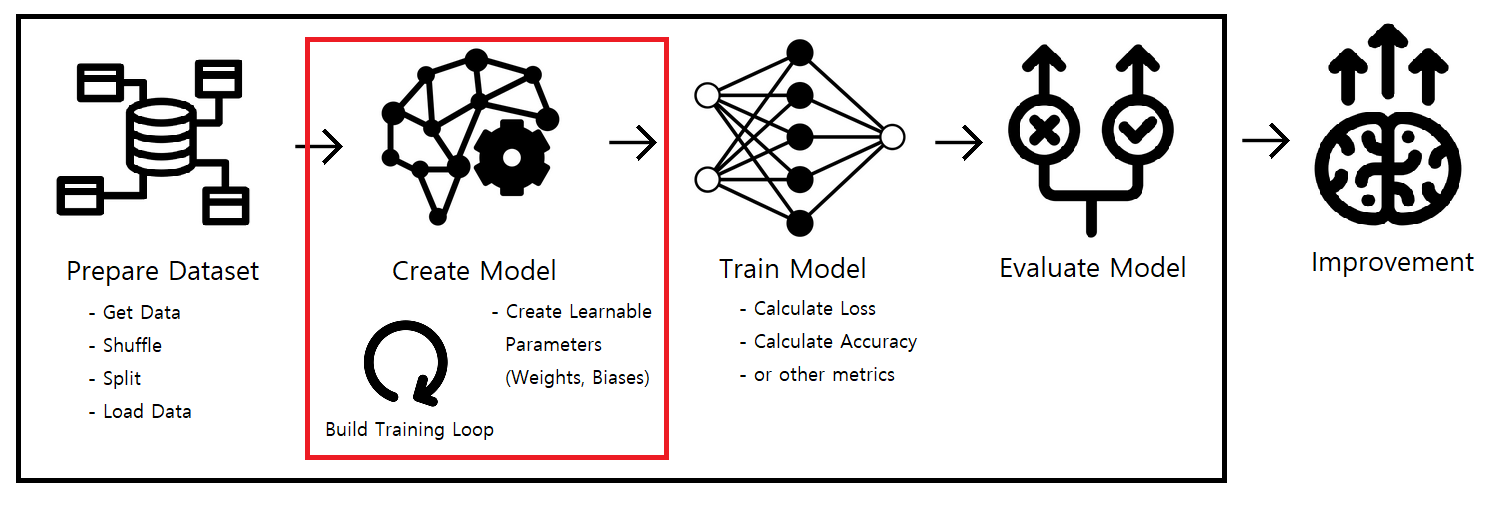

학습을 위한 데이터를 가져오고, 배치 크기만큼 나눠줬다. 다음은 이 데이터들을 사용할 모델을 만든다.  
모델을 만들기 전에 딥러닝이 어떻게 작동하는지 간단하게 아래에 작성했다.

### 2.1 Perceptron

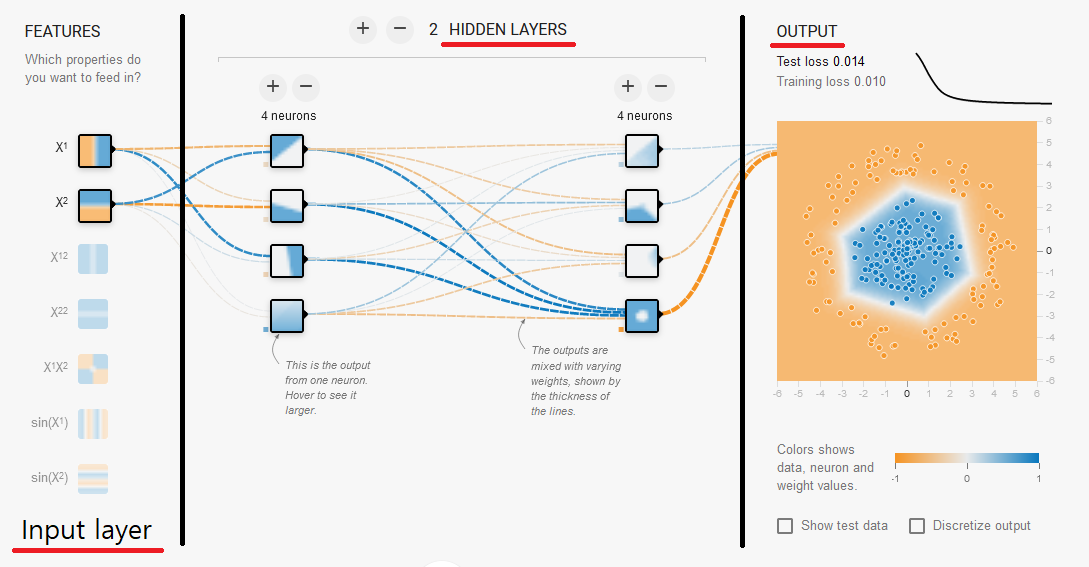

출처: [tensorflow playground](https://playground.tensorflow.org/)  

위 사진은 딥러닝에 대해 검색했을 때 가장 자주 만나게 되는 구조이다. 제일 왼쪽의 입력층부터 중간의 은닉층, 마지막으로 출력층이 나타난다. 입력층은 가지고 있는 데이터들의 특성을 입력받는 가장 첫번째 층이다. 입력 데이터의 크기만큼 퍼셉트론(뉴런)을 가진다. 다음 3개의 층이 은닉층이다. 은닉층은 이전 층으로부터 받은 데이터와 층 사이의 가중치들을 `선형 변환 (Linear transform)`한 결과가 들어간다. 은닉층의 깊이와 뉴런 수가 많아질수록 학습할 수 있는 데이터의 특성이 많아지게 된다. 마지막 층이 출력층이다. 위 사진은 가운데 있는 원인지 밖의 원인지 구분하는 이진 분류 문제로 뉴런이 하나인 출력층으로 볼 수 있다. 분류 문제의 경우 출력층의 결과가 예측한 타겟을 얼마나 확신하는지 확률로 반환하기 위해 시그모이드(이진 분류의 경우)나 소프트맥스(다중 분류) 함수를 추가해준다.

출력층까지의 계산은 간단한 선형 변환(Linear transformation) 식으로 표현된다.

$$
y = x A^T + b
$$

$x$는 층으로 입력되는 값들(이전 층의 출력), $A$는 층 사이의 가중치 행렬, $b$는 각 층의 의닛인 뉴런의 편향값, $y$는 각 뉴런의 출력이 된다.

각 층의 기본 단위인 퍼셉트론(뉴런)은 아래와 같이 그려볼 수 있다.

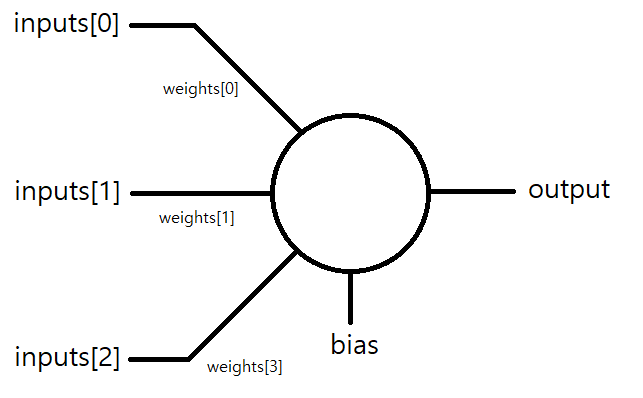

하나의 뉴련에 여러개의 입력을 받게 되면 각 입력마다 가중치를, 뉴런마다 편향을 가지게 된다. 이 뉴런의 출력의 위의 선형 변환 식을 통해 계산된다.

위 그림과 수식을 이용해 파이썬 코드를 간단히 작성해 본다면 아래와 같이 작성할 수 있다.

In [8]:
inputs = [1, 2, 1.5]
weights = [0.1, -0.3, 0.9] # 가중치는 초기에 랜덤으로 설정되지만 예시를 위해 임의로 두었다.
bias = 1.2 # 편향도 마찬가지로 무작위로 초기화되지만 임의의 값으로 두었다.

# 입력값과 가중치의 곱
output = inputs[0] * weights[0] + inputs[1] * weights[1] + inputs[2] * weights[2] + bias # xA + b

# 반복문 사용시
output = 0
for i in range(len(inputs)):
    output += inputs[i] * weights[i]
output += bias

print(f"The output of the perceptron is {output}")

The output of the perceptron is 2.05


위의 방식을 사용한다면 하나의 퍼셉트론이 아니라 여러개의 퍼셉트론을 동시에 계산할 수도 있다.

### 2.2 MultiPerceptron

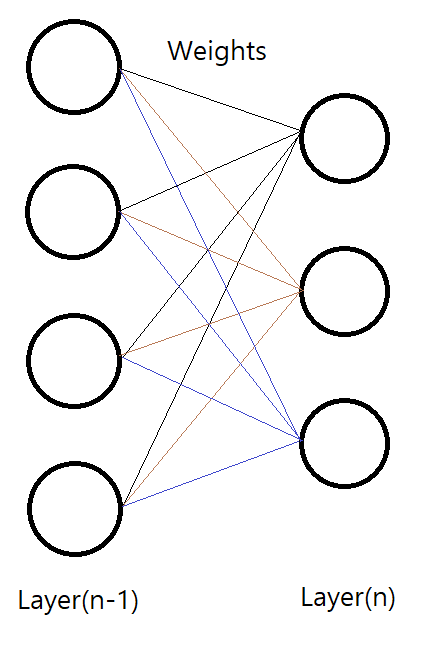

여러개의 퍼셉트론을 이용할 때는 위 그림처럼 이전 층의 퍼셉트론마다 다음 층의 퍼셉트론에 연결이 된다.  각 퍼셉트론마다 가중치가 있지만 그림에서는 생략했다. 이때는 각 출력 입력과 출력 사이의 가중치를 리스트 안의 리스트, `행렬`로 표현해 위의 수식을 그대로 사용하면 된다.

In [9]:
inputs = [1, 2, 1.5, 5] 
weights = [[0.7, -1.2, 0.4, -1.1], # 하나의 퍼셉트론을 사용할 때와 마찬가지로 계산 결과가 맞는지 확인하기 쉽도록 임의의 값으로 두었다.
           [1.1, -0.2, -0.7, 0.6],
           [1.6, -1, -0.6, 0.7]]
biases = [0.9, 0.5, -1.7]

# inputs[0]*weights[0][0] + inputs[0]*weights[0][1] + ... inputs[3]*weights[2][3] + biases
outputs = []
for i in range(len(weights)):
    output = 0
    for j in range(len(inputs)): # 입력에 해당하는 값과 입력에 연결된 여러 가중치들의 선형 변환을 실행한다.
        output += inputs[j]*weights[i][j]
    output += biases[i] # 다음 층에 있는 뉴런의 편향도 추가해준다.
    outputs.append(round(output, 2))
print(f"The output of Multi Perceptron: {outputs}")

# numpy의 dot product, numpy.dot을 사용하면 더 쉽게 구현 할 수 있다.
outputs = np.dot(inputs, np.array(weights).T) + biases
print(f"Output of MultiPerceptron with numpy.dot: {outputs} ")

The output of Multi Perceptron: [-5.7, 3.15, 0.5]
Output of MultiPerceptron with numpy.dot: [-5.7   3.15  0.5 ] 


<a name='create_parameters_biases'></a>
### 2.3 Linear Layer
이 선형 변환을 계속 사용할 수 있도록 위 과정을 클래스로 만들어준다. 언급했듯이 가중치와 편향은 `랜덤으로 초기화` 된다. 선형 변환 (Linear) 클래스 선언시 초기화 될 수 있도록 생성자에서 가중치와 편향을 `numpy`의 `random`을 사용해 초기화시켜준다. 가중치는 정규분포를 따르도록, 편향은 균일 분포를 따르게 했다. [PyTorch](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)에서는 입력 특성 수 제곱근의 역수 범위 내로 한정하지만 여기서는 편의상 -0.1과 0.1 사이로 제한했다.

In [10]:
class Linear:
    """Apply linear transform. Create weights and biases, 
    which shapes are weight: [in_features, out_features], biases: [out_features]
    The weights are initialized to normal distribution multiplied by 0.1 and
    biases are uniform distribution, multiplied by 0.1.
    Args:
        in_features (int): The number of features at input
        out_features (int): The number of output features (number of neurons at output)
    """
    def __init__(self, 
                 in_features:int, 
                 out_features:int):
        self.weights = 0.1 * np.random.randn(in_features, out_features)
        self.biases = 0.1 * np.random.uniform(-1, 1, out_features)
    
    def forward(self, x):
        """Calculate linear transform along input data with weights and biases"""
        return np.dot(x, self.weights) + self.biases

In [11]:
linear_layer = Linear(in_features=3, # 입력 뉴런(퍼셉트론)이 3개
                      out_features=5) # 출력 뉴런이 5개라면 

sample = np.random.randn(3, 3) # shape: [batch_size, input_features]

outputs = linear_layer.forward(sample)
print(f"Shapes of output: {outputs.shape}\noutputs: \n{outputs}")

Shapes of output: (3, 5)
outputs: 
[[-0.07259797  0.04102122 -0.07708097 -0.02566922  0.06542425]
 [ 0.078102    0.10667019  0.02602772  0.00665894 -0.08188517]
 [-0.09456042  0.13419394 -0.1467937  -0.05489215 -0.06395202]]


간단한 선형 회귀 문제로 Linear 층이 제대로 작동하는지 확인해보자.
<a name="exmaple"></a>

In [12]:
known_weights = 0.5 # 선형 함수 생성을 위한 가중치
known_bias = 0.2 # 편향

start = 0
end = 1
num = 50

X = np.linspace(start, end, num).reshape(-1, 1) # num개의 데이터로 만들기 위해 1 차원 추가해준다.
y = known_weights * X + known_bias

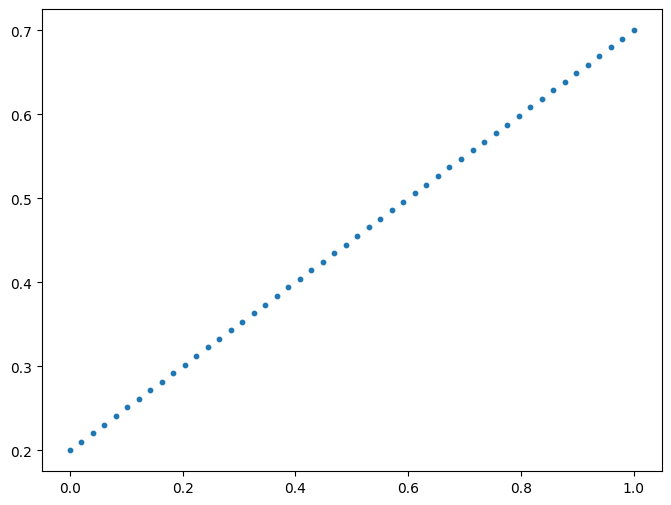

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, s=10)
plt.show()

예시 데이터중에 마지막 20%를 테스트 데이터로 사용한다.

In [14]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [15]:
linear_layer_0 = Linear(in_features=1, out_features=1)
y_preds = linear_layer_0.forward(X_test)

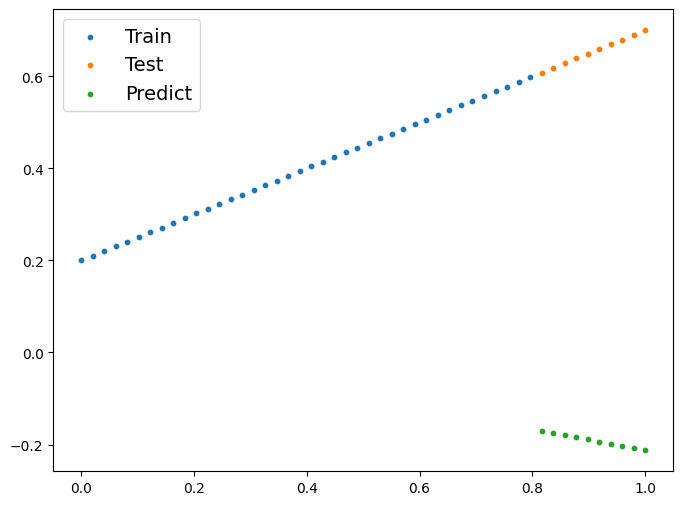

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, s=10, label='Train')
plt.scatter(X_test, y_test, s=10, label='Test')
plt.scatter(X_test, y_preds, s=10, label='Predict')
plt.legend(fontsize=14)
plt.show()

In [17]:
print(f"Weight: {linear_layer_0.weights[0][0]:.2f}, Bias: {linear_layer_0.biases[0]:.2f}")

Weight: -0.23, Bias: 0.02


제대로 출력되는것처럼 보인다. 하지만 실제 정답과 예측값과는 큰 차이가 보이는데 회귀 문제를 풀 경우 이 차이를 `손실`로 사용한다. 이 손실을 최소화 하는 방향으로 처음에 무작위로 설정되었던 가중치와 편향을 학습시키는 것이 딥러닝의 학습 방법이다. 학습은 구한 `손실(손실함수)`와 경사하강법 등을 사용한 `옵티마이저`를 사용해 `역전파`를 진행시키면서 **가중치와 편향을 수정**하는 과정이다. 이에 대한 설명은 이후에 설명하겠다. 분류 문제의 경우에는 얼마나 분류를 잘했는지를 기반으로 손실함수를 정의할 수 있다.

### 2.4 Loss function

손실 함수는 실제값과 모델이 예측한 값의 차이가 얼마나 나는지 보여주기 위해 사용한다. 낮을수록 좋으며 해결해야할 문제에 따라 사용하는 손실 함수를 선택할 수 있다. 이진 분류의 경우 BinaryCrossEntropyLoss를 사용하며, 다중 분류는 CategoricalCrossEntropyLoss, 회귀의 경우 Mean Square Loss 등을 사용한다. 대표적으로 이진 분류에 사용되는 BinaryCrossEntropyLoss는 수식으로 나타내면 다음과 같다.  
아래 그래프와 함께 보면 타겟이 1일 경우 예측값이 1에 가까울수록 손실이 줄어들고, 0에 가까울수록 손실이 급격하게 커진다. 타겟이 0일 경우에는 반대로 나타나 결국 두 클래스를 제대로 맞출 경우에 손실이 줄어들게 된다.

$$
BCELoss = -\frac{1}{N}\sum^{N}_{i=0} y_i \cdot \log(\hat{y_i}) + (1-y_i) \cdot \log(1-\hat{y_i})
$$



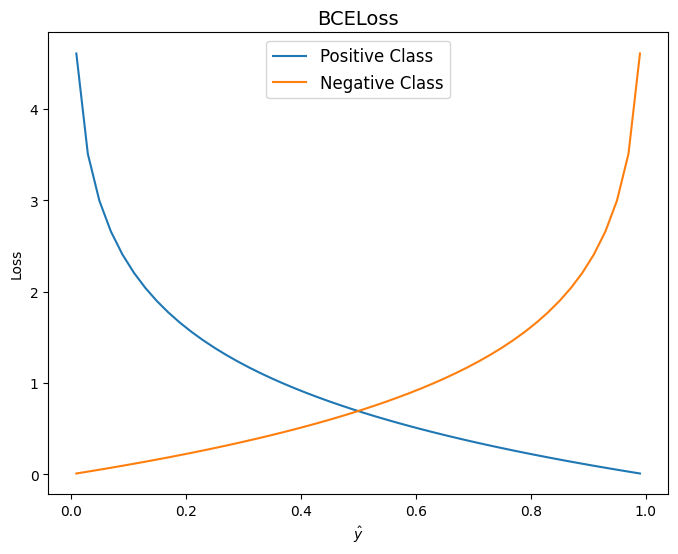

In [18]:
x = np.linspace(0.01, 0.99, 50)
plt.figure(figsize=(8, 6))
plt.plot(x, -np.log(x), label="Positive Class")
plt.plot(x, -np.log(1-x), label="Negative Class")
plt.title("BCELoss", fontsize=14)
plt.xlabel('$\hat{y}$')
plt.ylabel('Loss')
plt.legend(fontsize=12)
plt.show()

위 수식으로 구현하면

In [19]:
def BCELoss(true: np.array,
            pred: np.array):
    """Calculate binary cross entropy loss.
    Set boundary of `pred` [1e-7, 1-1e-7] to prevent values get close to 0 in log.
    Args:
        true: True label of dataset.
        pred: The output of the model. Contains the probability of prediction which is positive.
    
    Return: Binary cross entropy loss
    """
    pred = np.clip(pred, 1e-7, 1-1e-7)
    return - (true * np.log(pred) + (1-true) * np.log(1-pred))

### 2.5 Evaluate Metric

모델이 잘 학습했는지 확인하기 위한 용도로 평가 항목들을 추가할 수 있다. 위의 선형 회귀 문제 같은 경우는 실제 값과 예측한 값이 얼마나 떨어져있는지를 기반으로 한 Mean Absoulte Error나 Mean Square Error 등을 사용할 수 있다. 현재 과제로 진행하는 0과 1 이진 분류는 Accuracy, Recall, Precision, F1-score 등을 사용할 수 있다. 여기서는 실제 참인 값을 참으로 예측 했는지, 거짓인 값을 거짓으로 예측 했는지 정도를 알려주는 Accuracy를 사용한다.

$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

In [20]:
def Accuracy(true: np.array,
             pred: np.array):
    """Calcuate Accuracy.
    Get true label and prediction probability, and round probability to compare with true which data type is integer.
    Args:
        true: True label of dataset.
        pred: The output of the model. Contains the probability of prediction which is positive.

    Returns: Accuracy
    """
    acc = sum(pred.round()==true)
    return acc[0]

### 2.6 Activation function
위에서 봤던 선형 변환 식을 보면 알 수 있지만 단순히 선형 변환을 연결해주는 것은 단순히 선형 변환을 반환하는 것 밖에 되지 않는다. 이를 해소하기 위해 각 층의 출력에 `비선형성`을 부여할 수 있는 비선형 함수를 추가해준다. 대중적으로 사용하는 ReLU나 이진분류 출력에 많이 사용되는 sigmoid, 다중 분류에 사용되는 softmax 등이 있다.  
은닉층 사이에서는 일반적으로 ReLU가 많이 사용되고, 주어진 과제가 이진 분류 문제이므로 ReLU와 Sigmoid 두가지를 구현하고 모델에 추가한다.  
먼저 ReLU는 

$$
ReLU(x) = max(0, x)
$$

로 표현되며 그래프는 아래와 같다.

In [21]:
def ReLU(x):
    """Apply ReLU function to input"""
    return max(0, x)

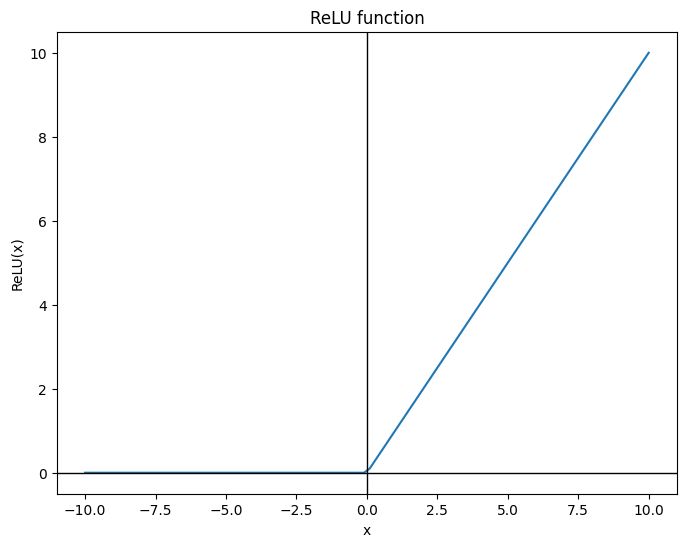

In [22]:
plt.figure(figsize=(8, 6))
x = np.linspace(-10, 10, 100)
plt.plot(x, list(map(ReLU, x)))
plt.title("ReLU function")
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.axhline(0, c='k', linewidth=1)
plt.axvline(0, c='k', linewidth=1)
plt.show()

Sigmoid의 식은 다음과 같다.

$$
Sigmoid(x) = \frac{1}{1+e^{-x}}
$$

In [23]:
def sigmoid(x):
    """Apply sigmoid function to input"""
    return 1 / (1 + np.exp(-x))

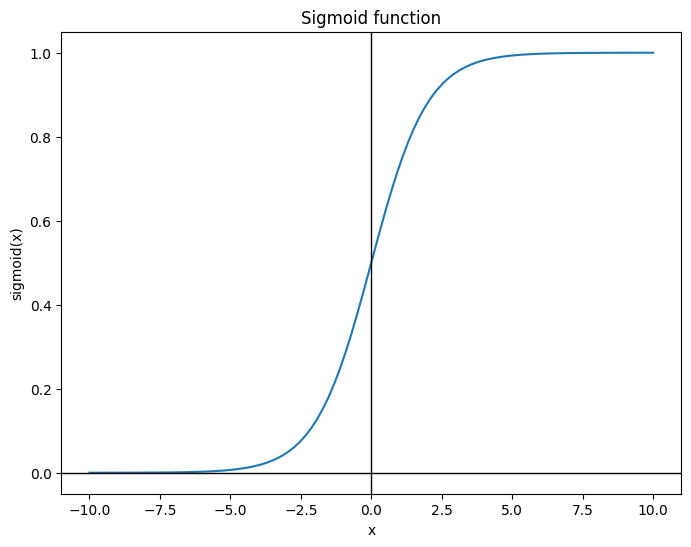

In [24]:
plt.figure(figsize=(8, 6))
x = np.linspace(-10, 10, 100)
plt.plot(x, sigmoid(x))
plt.title("Sigmoid function")
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.axhline(0, c='k', linewidth=1)
plt.axvline(0, c='k', linewidth=1)
plt.show()

Sigmoid 함수를 보면 출력값이 0과 1사이로 나타난다. 그래서 이진 분류에서 많이 사용되고 모델의 마지막 부분에 이 활성화 함수를 추가해 출력 결과를 확률로 나타내게 된다. 위에서 만든 `Linear` 층 사이에 `ReLU`를, 출력 부분에 `sigmoid`를 추가해 모델을 만들어보면 다음과 같다.

In [25]:
class ReLU:
    """
    Apply ReLU function.
    Forward method of ReLU object returns maximum value between 0 and input.
    """
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

class Sigmoid:
    """
    Apply Sigmoid function.
    Forward method of Sigmoid returns value between 0 and 1.
    If input much lager than 0, results will close to 1
    and lower than 0, then 0.
    """
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

In [26]:
class LinearModel:
    """Apply linear transform. 
    Between layers, apply ReLU activation function
    And apply sigmoid function to output of linear transform.
    
    Args:
        in_features (int): The number of features at input
        hidden_dim (int): The number of hidden layer's neuron.
        out_features (int): The number of output features (number of neurons at output)
    """
    def __init__(self,
                 in_features:int,
                 hidden_dim:int,
                 out_features:int):
        self.linear_layers = [Linear(in_features=in_features,
                                     out_features=hidden_dim),
                              ReLU(), # 선형 연결 층 사이의 활성화 함수
                              Linear(in_features=hidden_dim, # 입력층과 출력층 사이의 은닉층
                                     out_features=hidden_dim),
                              ReLU(),
                              Linear(in_features=hidden_dim,
                                     out_features=out_features),
                              Sigmoid()] # 확률로 출력하기 위한 활성화 함수

    def forward(self, x):
        for i in range(len(self.linear_layers)): # Linear 객체를 가져오면서 그 Linear 층을 통과시킨다.
            temp = self.linear_layers[i] 
            x = temp.forward(x)
        return x

In [27]:
linear_layer = LinearModel(in_features=3, # 입력 뉴런(퍼셉트론)이 3개
                           hidden_dim=10, # 은닉층 뉴런 10개
                           out_features=5) # 출력 뉴런이 5개라면 

sample = np.random.randn(1, 3) # shape: [batch_size, input_features]

outputs = linear_layer.forward(sample)
print(f"Shapes of output: {outputs.shape}\noutputs: \n{outputs}")

Shapes of output: (1, 5)
outputs: 
[[0.50942448 0.49629135 0.52125448 0.50843104 0.47817305]]


샘플 데이터로 결과를 봤을 때 모두 0과 1 사이의 확률값으로 나타난 것을 알 수 있다.

### 2.7 Back propagation
위 [선형 회귀 예제](#exmaple)를 보면 실제 타겟과 예측이 많이 차이가 나는 것을 확인할 수 있다. 이는 생성한 모델이 아직 학습을 진행하지 않고 가중치와 편향이 랜덤으로 설정되어있기 때문이다. 딥러닝에서는 위 예제에서 언급한 것 처럼 실제값과 예측값을 비교하고, 이 차이를 활용해 모델의 학습 가능한 파라미터들(가중치, 편향)을 업데이트 해준다. 파라미터들을 실제값과 출력층의 예측값으로부터 구한 손실함수에서 시작해서 입력층 직전 파라미터들까지 역전파를 진행하면서 업데이트 시켜준다.  
역전파는 손실함수가 출력층부터 입력층 아래까지 층 사이의 파라미터들에 의해 얼마나 변하는냐를 구하고 파라미터를 수정하는 과정이다. 때문에 *가중치에 대한 손실함수의 변화량*을 구해주면 된다. 손실함수가 구해지는 과정은 입력이 모델의 각 층에 해당하는 함수를 통과하는 것으로, 손실함수의 변화량은 반대로 ***연쇄법칙을 이용한 미분***으로 구한다.

선형 회귀 예제의 손실함수를 Mean Square Error 라고 두고 적용시켜보면 입력이 $x_0$, 가중치가 $w_0$ 일 때

$$
\frac{\partial}{\partial \, w_0}[MSE(sum(mul(x_0, w_0), b))] \\
= \frac{d \, MSE}{d \, sum()} \cdot \frac{\partial \, sum()}{\partial \, mul(x_0, w_0)} \cdot \frac{\partial \, mul(x_0, w_0)}{\partial \, x_0}
$$

로 표현할 수 있다. 이에 해당하는 것들을 코드로 작성하면 아래와 같다.

$loss = (xW + b - y)^2$

$ \frac{\partial \, loss}{\partial W} = 2 * (xW+b-y)*x$

$ \frac{\partial \, loss}{\partial b} = 2 * (xW+b-y)$

In [28]:
linear_layer = Linear(in_features=1, out_features=1)
test_preds = linear_layer.forward(X_test)

In [29]:
learning_rate = 0.01
epochs = 100

print(f"Target Weight: {known_weights}, Bias: {known_bias}")
for epoch in range(epochs):
    # 순전파 과정, 모델로 값을 예측한다.
    y_preds = linear_layer.forward(X_train)
    # 손실 계산, MSE를 계산한다.
    loss = 0.5*(y_preds - y_train)**2
    # 역전파를 위해 미분값을 구한다
    d_loss = (y_preds - y_train)
    # 위 식을 이용해 각 파라미터별 변화량을 구한다.
    dw = np.dot(X_train.T, d_loss)
    db = sum(y_preds - y_train)

    # 구한 변화량에 학습률을 곱해 파라미터를 수정해준다.
    linear_layer.weights -= dw * learning_rate
    linear_layer.biases -= db * learning_rate
 
    # 10회마다 결과 출력
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.mean():.4f} | Weight: {linear_layer.weights[0][0]:.4f} | Bias : {linear_layer.biases[0]:.4f}")

Target Weight: 0.5, Bias: 0.2
Epoch: 0 | Loss: 0.1323 | Weight: 0.0784 | Bias : 0.1040
Epoch: 10 | Loss: 0.0021 | Weight: 0.2318 | Bias : 0.3116
Epoch: 20 | Loss: 0.0014 | Weight: 0.2788 | Bias : 0.2924
Epoch: 30 | Loss: 0.0010 | Weight: 0.3175 | Bias : 0.2762
Epoch: 40 | Loss: 0.0007 | Weight: 0.3494 | Bias : 0.2629
Epoch: 50 | Loss: 0.0004 | Weight: 0.3757 | Bias : 0.2519
Epoch: 60 | Loss: 0.0003 | Weight: 0.3975 | Bias : 0.2428
Epoch: 70 | Loss: 0.0002 | Weight: 0.4154 | Bias : 0.2354
Epoch: 80 | Loss: 0.0001 | Weight: 0.4302 | Bias : 0.2292
Epoch: 90 | Loss: 0.0001 | Weight: 0.4424 | Bias : 0.2241


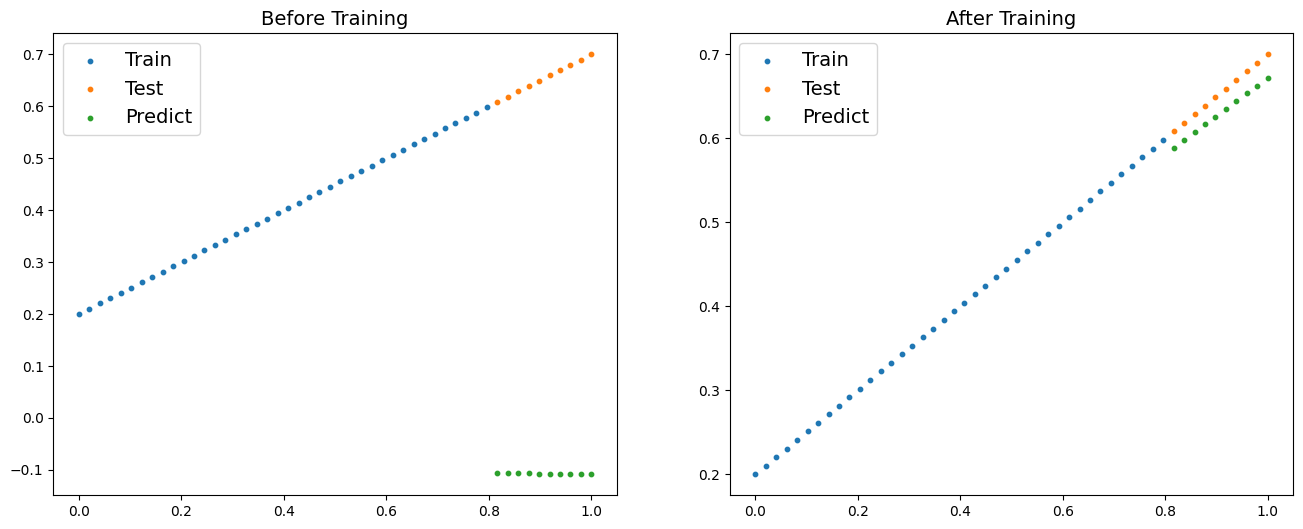

In [30]:
test_preds_with_back_propagation = linear_layer.forward(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, preds in enumerate([test_preds, test_preds_with_back_propagation]):
    axes[i].scatter(X_train, y_train, s=10, label='Train')
    axes[i].scatter(X_test, y_test, s=10, label='Test')
    axes[i].scatter(X_test, preds, s=10, label='Predict')
    if i == 0:
        title = 'Before Training'
    elif i == 1:
        title = 'After Training'
    axes[i].set_title(title, fontsize=14)
    axes[i].legend(fontsize=14)
plt.show()

이렇게 역전파를 진행해 가중치와 편향이 목표로 지정했던 값에 가까워지는 것을 확인할 수 있다.  
이처럼 모델에 사용하는 모든 층에 미분을 구하고 출력부터 수정하려는 가중치까지 연쇄법칙으로 수정하면 된다.

### 2.8 Optimizer

위 코드에 보면 파라미터를 수정하는 과정이 있는데 
```python
# 구한 변화량에 학습률을 곱해 파라미터를 수정해준다.
linear_layer.weights -= dw * learning_rate
linear_layer.biases -= db * learning_rate
```
이 작업을 해주는 기능을 optimizer라고 한다. 단순히 구한 손실에 대한 가중치 변화량에 학습률을 곱해 반대 방향으로 옮겨주는 optimizer는 SGD라고 한다. 여기에 모멘텀을 추가한다던지, 업데이트 하는 방식을 수정하면서 다른 optimizer로 변형 시킬 수 있다.  
학습률은 변화량의 얼마만큼을 파라미터 수정에 사용할지 결정한다. 학습률이 높을 경우 학습이 빠르게 진행되지만 파라미터가 어느 수준 이하 단위로는 바뀌지 않아 최적값에 도달하지 못 할 수도 있다. 반대로 너무 낮을 경우에는 학습에 너무 오랜시간이 걸리게 되고, 지역 최솟값에서 벗어나지 못해 전역 최솟값에 도달하지 못 할 수도 있다.

#### Update Layers with back propagation
사용한 층들에 역전파 과정을 추가해주고 파라미터를 업데이트하는 optimizer를 만들어 훈련 과정에 추가할 수 있도록 한다. Optimizer는 가장 간단한 모멘텀이 없는 단순한 SGD를 사용한다. 코드에 활용한 수학적인 과정들은 [Appendix](#derivative)에 정리해두었다.

In [31]:
class Linear:
    """Apply linear transform. Create weights and biases, 
    which shapes are weight: [in_features, out_features], biases: [out_features]
    The weights are initialized to normal distribution multiplied by 0.1 and
    biases are uniform distribution, multiplied by 0.1.
    Args:
        in_features (int): The number of features at input
        out_features (int): The number of output features (number of neurons at output)
    """
    def __init__(self, 
                 in_features:int, 
                 out_features:int):
        self.weights = 0.1 * np.random.randn(in_features, out_features)
        self.biases = 0.1 * np.random.uniform(-1, 1, out_features)
        # self.biases = np.zeros(out_features)
    
    def forward(self, inputs):
        """Calculate linear transform along input data with weights and biases
        The equation of linear transform is $y = xA + b$"""
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.biases

    def backward(self, dvalues):
        """
        Calculate difference of `dvalues` by weights and biases. 
        The `dvalues` are output of before layer while back propagation
        """
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs



class BCELoss:
    """
    Calculate binary cross entropy loss.
    Set boundary of `pred` [1e-7, 1-1e-7] to prevent values get close to 0 in log.
    """

    def forward(self, true, pred):
        """
        Args:
            true: True label of dataset.
            pred: The output of the model. Contains the probability of prediction which is positive.
        """
        self.true = true
        self.pred = np.clip(pred, 1e-7, 1-1e-7)

        self.loss = -(self.true * np.log(self.pred) + (1-self.true) * np.log(1-self.pred))
        return self.loss

    def backward(self, dvalue):
        self.dvalue = np.clip(dvalue, 1e-7, 1-1e-7)
        return -(self.true / self.dvalue - (1 - self.true) / (1 - self.dvalue))
        

class ReLU:
    """
    Apply ReLU function.
    Forward method of ReLU object returns maximum value between 0 and input.
    """
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        return dvalues * np.where(self.output > 0, 1, 0)


class Sigmoid:
    """
    Apply Sigmoid function.
    Forward method of Sigmoid returns value between 0 and 1.
    If input much lager than 0, results will close to 1
    and lower than 0, then 0.
    """
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, dvalues):
        return dvalues * self.output * (1 - self.output)

In [32]:
class LinearModel:
    """Apply linear transform. 
    Between layers, apply ReLU activation function
    And apply sigmoid function to output of linear transform.
    
    Args:
        in_features (int): The number of features at input
        hidden_dim (int): The number of hidden layer's neuron.
        out_features (int): The number of output features (number of neurons at output)
    """
    def __init__(self,
                 in_features:int,
                 hidden_dim:int,
                 out_features:int):
        self.layers = [Linear(in_features=in_features,
                              out_features=hidden_dim),
                       ReLU(), # 선형 연결 층 사이의 활성화 함수
                       Linear(in_features=hidden_dim, # 입력층과 출력층 사이의 은닉층
                              out_features=hidden_dim),
                       ReLU(),
                       Linear(in_features=hidden_dim,
                              out_features=out_features),
                       Sigmoid()] # 확률로 출력하기 위한 활성화 함수

    # 순전파
    def forward(self, x):
        for i in range(len(self.layers)): # Linear 객체를 가져오면서 그 Linear 층을 통과시킨다.
            temp = self.layers[i] 
            x = temp.forward(x)
        return x

    # 역전파
    def backward(self, dvalues):
        for i in range(len(self.layers)-1, -1, -1): # 역전파는 순전파와 반대로 출력부터 통과하게 된다.
            temp = self.layers[i]
            dvalues = temp.backward(dvalues)
        return dvalues

In [33]:
class SGD:
    """Stochastic Gradient Descent. Use learning rate and derivatives of layers,
    update parameters to minimize the loss. Learning rate determines how much of derivatives 
    effect the parameter changes.
    Only used in training step.
    """
    def __init__(self,
                 lr=1e-3):
        self.lr = lr

    def zero_grad(self, model): 
        """
        Initialize difference of weights and biases to zero  
        which is learnable parameters in model

        Args:
            model: Sequential model or layer that learnable parameters included.
        """
        for layer in model.layers[::-1]:
            if isinstance(layer, Linear):
                layer.dweights = 0
                layer.dbiases = 0

    def step(self, model):
        """
        Update te weigths and biases of layer which has learnable parameters.

        Args:
            model: model which used in training, initialized to zero by `zero_grad`.
        """
        for layer in model.layers[::-1]:
            if isinstance(layer, Linear):
                layer.weights -= (self.lr * layer.dweights)
                layer.biases -= (self.lr * layer.dbiases)

### 2.9 Build Training Loop

이제 위에서 정의한 `모델`과 `손실함수`, `optimizer`, `정확도 함수`를 가지고 훈련 루프를 만든다.
데이터는 위에서 만든 `데이터로더`를 사용해 미니배치만큼씩 가져와서 훈련한다.

In [34]:
in_features = binary_df.shape[1] - 1 # 데이터프레임의 마지막 값은 타겟이므로 제외하고 입력층에 통과시킨다.
hidden_dim = 20 # 은닉층의 뉴런 수는 임의로 20개로 둔다.
out_features = 1 # 출력은 예측값이 1인지 확률을 나타내도록 하면 되므로 1개로 둔다.

loss_fn = BCELoss() # 손실은 Binary Cross Entropy
optimizer = SGD(lr=0.001) # optimizer는 SGD를 이용한다.

model_0 = LinearModel(in_features=in_features,
                      hidden_dim=hidden_dim,
                      out_features=out_features)

In [35]:
EPOCHS = 1000

for epoch in range(EPOCHS):

    # 훈련 과정
    train_loss, train_acc = 0, 0 # 훈련 결과 초기화

    # 훈련 데이터로더로 훈련 데이터 가져오기
    for X, y in train_dataloader.getitem():

        # 순전파를 통한 확률 예측
        y_pred_prob = model_0.forward(X)

        # 손실 계산
        loss = loss_fn.forward(y, y_pred_prob)

        # optimizer 초기화
        optimizer.zero_grad(model_0)

        # 손실함수 역전파
        dvalues = loss_fn.backward(y_pred_prob)
        # 모델 역전파
        model_0.backward(dvalues)

        # 모델 학습 가능한 파라미터 업데이트
        optimizer.step(model_0)

        # 배치사이즈 만큼 더해졌으므로 그만큼 나눠준다. 훈련 손실과 정확도 업데이트
        train_loss += loss.sum() / train_dataloader.batch_size
        train_acc += Accuracy(y, y_pred_prob) / train_dataloader.batch_size

    # 데이터로더의 길이만큼 더해졌으므로 그만큼 손실과 정확도를 나눠준다.
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 테스트 과정
    test_loss, test_acc = 0, 0 # 테스트 결과 초기화

    # 테스트 데이터로더로 테스트 데이터 가져오기
    for X_test, y_test in test_dataloader.getitem():

        # 순전파를 통한 예측 진행
        test_pred_prob = model_0.forward(X_test)

        # 손실 계산 
        loss = loss_fn.forward(y_test, test_pred_prob)

        # 훈련 과정과 똑같이 테스트 손실과 정확도 업데이트
        test_loss += loss.sum() / test_dataloader.batch_size
        test_acc += Accuracy(y_test, test_pred_prob) / test_dataloader.batch_size
            
    # 훈련 과정과 똑같이 테스트 손실과 정확도 업데이트
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    # 훈련, 테스트 결과 출력
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Acc: {test_acc:.4f}")

Epoch: 0 | Train Loss: 0.7035 | Train Acc: 0.2500 | Test Loss: 0.6680 | Test Acc: 0.5000
Epoch: 100 | Train Loss: 0.6062 | Train Acc: 0.8125 | Test Loss: 0.6236 | Test Acc: 0.7500
Epoch: 200 | Train Loss: 0.5446 | Train Acc: 0.8125 | Test Loss: 0.5395 | Test Acc: 0.7500
Epoch: 300 | Train Loss: 0.5029 | Train Acc: 0.8125 | Test Loss: 0.4614 | Test Acc: 0.7500
Epoch: 400 | Train Loss: 0.4783 | Train Acc: 0.8125 | Test Loss: 0.4123 | Test Acc: 0.7500
Epoch: 500 | Train Loss: 0.4606 | Train Acc: 0.8125 | Test Loss: 0.3717 | Test Acc: 0.7500
Epoch: 600 | Train Loss: 0.4461 | Train Acc: 0.8125 | Test Loss: 0.3320 | Test Acc: 0.7500
Epoch: 700 | Train Loss: 0.4315 | Train Acc: 0.8125 | Test Loss: 0.2861 | Test Acc: 1.0000
Epoch: 800 | Train Loss: 0.4162 | Train Acc: 0.8125 | Test Loss: 0.2372 | Test Acc: 1.0000
Epoch: 900 | Train Loss: 0.3989 | Train Acc: 0.8750 | Test Loss: 0.1878 | Test Acc: 1.0000


위 훈련 과정을 재사용 할 수 있도록 함수로 만들어준다. 함수는 `훈련 과정`, `테스트 과정`을 작성하고 에포크마다 둘을 반복하는 `전체 과정`을 포함하는 함수를 작성해준다.

In [36]:
def train_step(model,
               dataloader:DataLoader,
               loss_fn,
               optimizer,
               accuracy_fn):
    """
    Get data from DataLoader, run through training step which contains 
    (forward pass, loss calculation, optimzier initialize, back propagation, optimizer step).
    
    Args:
        model: Linear model to train.
        dataloader: Data generator, to be trained on model.
        loss_fn: Loss function to minimize.
        optimizer: Update parameters by using loss_fn and layers backward methods.
        accuracy_fn: Function to calculate accuracy.

    Returns:
        train_loss: Overall loss on one epoch using training data.
        train_acc: Overall accuracy on one epoch using training data.
    """
    train_loss, train_acc = 0, 0 # 훈련 결과 초기화

     # 훈련 데이터로더로 훈련 데이터 가져오기
    for X, y in dataloader.getitem():

        # 순전파를 통한 확률 예측
        y_pred_prob = model.forward(X)

        # 손실 계산
        loss = loss_fn.forward(y, y_pred_prob)

        # optimizer 초기화
        optimizer.zero_grad(model)

        # 손실함수 역전파
        dvalues = loss_fn.backward(y_pred_prob)
        # 모델 역전파
        model.backward(dvalues)

        # 모델 학습 가능한 파라미터 업데이트
        optimizer.step(model)

        # 배치사이즈 만큼 더해졌으므로 그만큼 나눠준다. 훈련 손실과 정확도 업데이트
        train_loss += loss.sum() / dataloader.batch_size
        train_acc += accuracy_fn(y, y_pred_prob) / dataloader.batch_size

    # 데이터로더의 길이만큼 더해졌으므로 그만큼 손실과 정확도를 나눠준다.
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(model,
              dataloader,
              loss_fn,
              accuracy_fn):
    """
    Get data from DataLoader, run through test step which contains (forward pass, loss calculation). 
    Unlike training step, test step doesn't have optimizer step and back propagation.

    Args:
        model: Linear model to be tested.
        dataloader: Data generator, to be tested on model.
        loss_fn: Loss function to minimize.
        accuracy_fn: Function to calculate accuracy.

    Returns:
        train_loss: Overall loss on one epoch using test data.
        train_acc: Overall accuracy on one epoch using test data.
    """
    test_loss, test_acc = 0, 0 # 테스트 결과 초기화

    # 테스트 데이터로더로 테스트 데이터 가져오기
    for X_test, y_test in dataloader.getitem():

        # 순전파를 통한 예측 진행
        test_pred_prob = model.forward(X_test)

        # 손실 계산 
        loss = loss_fn.forward(y_test, test_pred_prob)

        # 훈련 과정과 똑같이 테스트 손실과 정확도 업데이트
        test_loss += loss.sum() / dataloader.batch_size
        test_acc += accuracy_fn(y_test, test_pred_prob) / dataloader.batch_size
            
    # 훈련 과정과 똑같이 테스트 손실과 정확도 업데이트
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

def train(model,
          train_dataloader,
          test_dataloader,
          loss_fn,
          optimizer,
          accuracy_fn,
          epochs):
    """
    Pass model through train_step() and test_step(), repeat as many as epochs.
    
    Args:
        model: Linear model to train and to be tested.
        train_dataloader: Dataloader used in train step.
        test_dataloader: Dataloader usesd in test step.
        loss_fn: Loss function to minimize.
        optimizer: Update trainable parameters.
        accuracy_fn: Function to calculate accuracy.
        epochs: How many times training loop repeat.

    Returns:
        results (Dict[str, List]): Results of training step and test step. 
            Loss value and Accuracy for each step for epochs.
    """
    # 결과 초기화
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
   
    # 에포크마다 반복
    for epoch in range(epochs):
        # 훈련 과정을 진행하고 손실과 정확도 계산
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn)
        # 테스트 과정을 진행하고 손실과 정확도 계산
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        
        # 결과 딕셔너리에 훈련과 테스트 결과(손실, 정확도) 저장
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        # 결과 출력
        if (epoch % (epochs//10) == 0) or (epoch == epochs-1):
            print(f"[Epochs {epoch+1}/{epochs}] | "
                f"Train Loss: {train_loss:.4f} | "
                f"Train Accuracy: {train_acc:.4f} | "
                f"Test Loss: {test_loss:.4f} | "
                f"Test Accuracy: {test_acc:.4f}")
        
    return results

## 3. Train and evaluate model

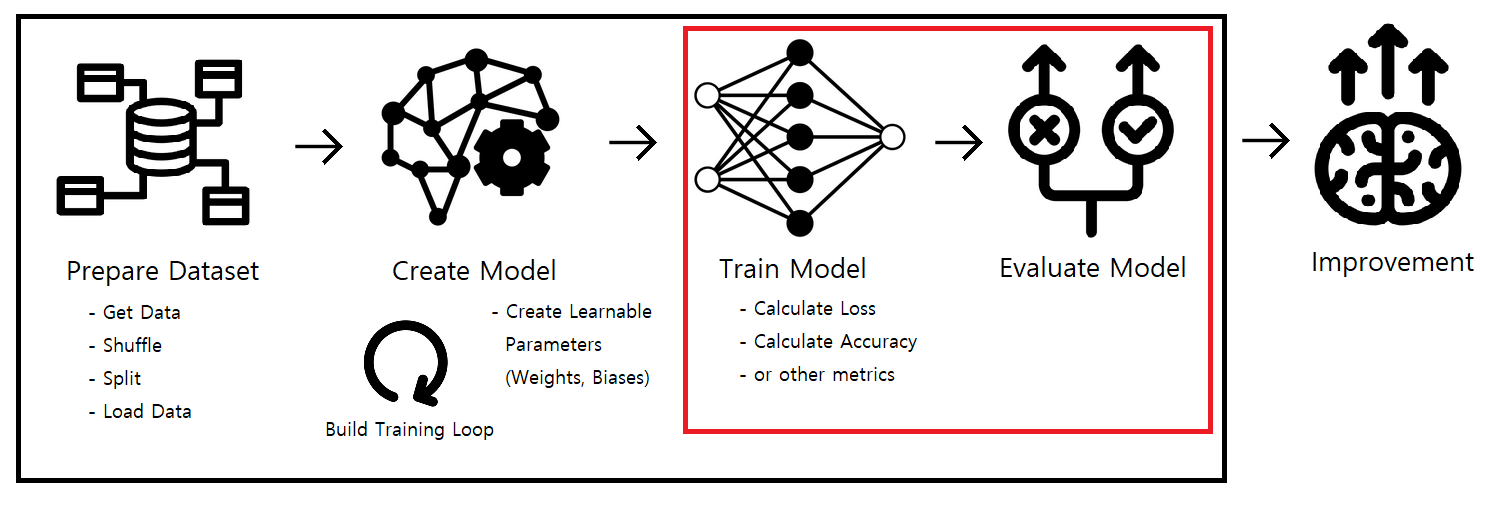

2.7에서 만든 훈련 루프를 사용해 모델을 학습시킨다.  
훈련 과정에 테스트 세트를 사용해 모델 평가도 진행했다. 

In [37]:
in_features = binary_df.shape[1] - 1 # 데이터프레임의 마지막 값은 타겟이므로 제외하고 입력층에 통과시킨다.
hidden_dim = 20 # 은닉층의 뉴런 수는 임의로 20개로 둔다.
out_features = 1 # 출력은 예측값이 1인지 확률을 나타내도록 하면 되므로 1개로 둔다.

model_0 = LinearModel(in_features=in_features,
                      hidden_dim=hidden_dim,
                      out_features=out_features)

In [38]:
results = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=BCELoss(),
                optimizer=SGD(lr=0.001),
                accuracy_fn=Accuracy,
                epochs=1000)

[Epochs 1/1000] | Train Loss: 0.6977 | Train Accuracy: 0.2500 | Test Loss: 0.6822 | Test Accuracy: 0.5000
[Epochs 101/1000] | Train Loss: 0.6025 | Train Accuracy: 0.8125 | Test Loss: 0.6424 | Test Accuracy: 0.7500
[Epochs 201/1000] | Train Loss: 0.5182 | Train Accuracy: 0.8125 | Test Loss: 0.5437 | Test Accuracy: 0.7500
[Epochs 301/1000] | Train Loss: 0.4521 | Train Accuracy: 0.8125 | Test Loss: 0.4029 | Test Accuracy: 0.7500
[Epochs 401/1000] | Train Loss: 0.4153 | Train Accuracy: 0.8125 | Test Loss: 0.2903 | Test Accuracy: 0.7500
[Epochs 501/1000] | Train Loss: 0.3910 | Train Accuracy: 0.8125 | Test Loss: 0.2074 | Test Accuracy: 1.0000
[Epochs 601/1000] | Train Loss: 0.3698 | Train Accuracy: 0.8750 | Test Loss: 0.1529 | Test Accuracy: 1.0000
[Epochs 701/1000] | Train Loss: 0.3506 | Train Accuracy: 0.8750 | Test Loss: 0.1159 | Test Accuracy: 1.0000
[Epochs 801/1000] | Train Loss: 0.3333 | Train Accuracy: 0.8750 | Test Loss: 0.0891 | Test Accuracy: 1.0000
[Epochs 901/1000] | Train Loss

## 3.1 Save and Load model

모델 재사용을 위해 모델을 pickle 형식으로 저장해준다.

In [39]:
import pickle

def save_model(model,
               model_name,
               save_dir):
    """
    Save model by pickle file to save_dir for model reusablity.

    Args: 
        model: Target model to save.
        model_name: Target name model will be saved.
            model_name should ends with 'pickle'
        save_dir: Target directory where model to saved.
    """
    save_dir = Path(save_dir)
    if not save_dir.is_dir():
        save_dir.mkdir(exist_ok=True, parents=True)

    assert model_name.endswith('.pickle'), "model_name should ends with '.pickle'"

    with open(save_dir / model_name, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model file saved in {save_dir/model_name}")

def load_model(model_name,
               saved_dir):
    """
    Load model from saved directory.

    Args:
        model_name: Model name to load from directory.
            Model name should ends with 'pickle'
        saved_dir: Directory where the saved model is in.

    Returns:
        model: 
    """
    saved_dir = Path(saved_dir)

    assert model_name.endswith('.pickle'), "model_name should ends with '.pickle'"

    with open(saved_dir / model_name, 'rb') as f:
        model = pickle.load(f)

    print(f"Model successfully loaded!")
    return model

## 4. Putting it all in one

하나의 함수 호출로 모든 과정을 실행 시킬 수 있도록 main 함수를 정의한다.  
이 함수는 데이터를 불러오는 것부터 훈련, 테스트 데이터 분리, 데이터로더 생성, 학습할 모델 생성, 모델 훈련 및 테스트 까지 진행한다.

In [40]:
def main():
    """
    Train binary classification model.
    """
    # 하이퍼 파라미터 지정
    EPOCHS = 500
    BATCH_SIZE = 4

    MODEL_DIR = 'model'
    MODEL_NAME = 'binary_classifier.pickle'

    hidden_dim = 20
    out_features = 1

    # 데이터 불러오기
    binary_df = download_data()

    # 훈련, 테스트 데이터 분리 + 섞기
    train_df, test_df = train_test_split(binary_df)

    # 데이터 표준화
    std_scaler = Standardizaion()
    std_scaler.fit(train_df[:, :-1])
    train_df[:, :-1] = std_scaler.transform(train_df[:, :-1])
    test_df[:, :-1] = std_scaler.transform(test_df[:, :-1])

    # 배치 사이즈만큼 데이터를 넘겨주는 훈련, 테스트 데이터로더 객체 생성
    train_dataloader = DataLoader(train_df, 
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)
    test_dataloader = DataLoader(test_df,
                                 batch_size=BATCH_SIZE,
                                 shuffle=False)
    
    # 모델 생성
    model = LinearModel(in_features=binary_df.shape[1]-1,
                        hidden_dim=20,
                        out_features=out_features)
    
    # 손실 함수 정의
    loss_fn = BCELoss()
    # optimizer 정의
    optimizer = SGD(lr=0.001)
    # 정확도 계산 함수 정의
    accuracy_fn = Accuracy

    # 훈련 과정 진행
    results = train(model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    epochs=EPOCHS)

    save_model(model, 'binary_classifier.pickle', 'model')

# ***프로젝트 결론***

In [41]:
main()

[Epochs 1/500] | Train Loss: 0.6876 | Train Accuracy: 0.6875 | Test Loss: 0.6818 | Test Accuracy: 1.0000
[Epochs 51/500] | Train Loss: 0.6598 | Train Accuracy: 0.6875 | Test Loss: 0.6386 | Test Accuracy: 0.7500
[Epochs 101/500] | Train Loss: 0.6373 | Train Accuracy: 0.6875 | Test Loss: 0.5962 | Test Accuracy: 0.7500
[Epochs 151/500] | Train Loss: 0.6173 | Train Accuracy: 0.7500 | Test Loss: 0.5541 | Test Accuracy: 1.0000
[Epochs 201/500] | Train Loss: 0.5949 | Train Accuracy: 0.7500 | Test Loss: 0.5018 | Test Accuracy: 1.0000
[Epochs 251/500] | Train Loss: 0.5683 | Train Accuracy: 0.7500 | Test Loss: 0.4366 | Test Accuracy: 1.0000
[Epochs 301/500] | Train Loss: 0.5369 | Train Accuracy: 0.7500 | Test Loss: 0.3623 | Test Accuracy: 1.0000
[Epochs 351/500] | Train Loss: 0.5045 | Train Accuracy: 0.7500 | Test Loss: 0.2915 | Test Accuracy: 1.0000
[Epochs 401/500] | Train Loss: 0.4758 | Train Accuracy: 0.8125 | Test Loss: 0.2349 | Test Accuracy: 1.0000
[Epochs 451/500] | Train Loss: 0.4509 | 

In [42]:
# 모델 불러오기
model_loaded = load_model('binary_classifier.pickle', 'model')

# 샘플 데이터로 모델이 잘 작동하는지 확인
for i in range(10):
    test_sample = binary_df.sample(1).to_numpy()
    X_sample, y_sample = test_sample[:, :-1], test_sample[:, -1]
    y_pred_prob = model_loaded.forward(X_sample)[0][0]
    y_pred = y_pred_prob.round()
    if y_sample[0] == y_pred:
        color = "\033[0;32m"
    else:
        color = "\033[0;31m"
    if y_pred == 0:
        y_pred_prob = 1 - y_pred_prob
    print(f"{color}True label: {y_sample[0]} | Predict: {y_pred}, Prob: {y_pred_prob:.4f}")

Model successfully loaded!
True label: 0.0 | Predict: 0.0, Prob: 0.9998
True label: 0.0 | Predict: 0.0, Prob: 0.9998
True label: 1.0 | Predict: 0.0, Prob: 1.0000
True label: 0.0 | Predict: 1.0, Prob: 0.9989
True label: 0.0 | Predict: 0.0, Prob: 0.9999
True label: 1.0 | Predict: 1.0, Prob: 0.9831
True label: 0.0 | Predict: 1.0, Prob: 0.5619
True label: 0.0 | Predict: 0.0, Prob: 0.9928
True label: 1.0 | Predict: 1.0, Prob: 0.9891
True label: 0.0 | Predict: 1.0, Prob: 0.9989


손실을 학습이 진행될 수록 내려가고 정확도는 올라간다. 순전파와 역전파가 제대로 실행되면서 처음에 랜덤으로 설정된 선형 층의 파라미터(가중치와 편향)가 업데이트되고 있다.  
하지만 테스트 데이터가 4개밖에 없기 때문에 정확도 편차가 크게 나타난다. 학습이 잘되지 않는 경우도 있어서 손실이 늘어나는 경우도 있고, 테스트 정확도가 0.5에 머물러 있는 경우도 있다. 이에 대해서 여러가지를 생각해 볼 수 있다.
첫 번째로는 랜덤으로 만든 가중치와 편향이다. 초기 딥러닝에서는 이 랜덤으로 설정된 가중치 때문에 학습이 진행되지 않았다. 이후 다른 초기화 기법(Xavier 초기화, He 초기화 등)을 사용하면서 모델의 학습 능력이 더 좋아졌다.
두 번째로는 데이터 분포의 문제를 볼 수 있다. 현재 프로젝트에서는 학습 전 훈련 데이터를 기반으로 전체 데이터를 표준화 시켜주었다. 하지만 위에서 언급했듯이 이런 작업이 비선형성을 줄여 모델 훈련이 잘 안될 수도 있다. 때문에 배치 정규화같은 방법으로 분포를 학습시키고 사용하는 경우가 있다.  
세 번째로는 데이터 수이다. 딥러닝은 훈련에 사용되는 데이터의 수가 많아질수록 성능이 좋아진다. 하지만 현재 모델 훈련에 사용된 데이터는 16개 밖에 없다. 적은 수의 데이터로 학습한 모델은 일반화 성능이 좋지않을 수 있으며 테스트 데이터도 4개밖에 되지 않아 성능을 정확히 판단하기 어려울 수 있다. 이때에는 데이터를 더 수집하거나 이미지의 경우에는 많이 사용하는 Data Augmentation을 고려해 볼 수 있다.

# Appendix

<a name="derivative"></a>
## A. Derivatives

역전파가 진행되는 과정은
```
손실함수 -> 클래스 확률을 위한 Sigmoid -> Linear 층 (선형 변환) -> ReLU (비선형성 추가) -> Linear 층 -> ...
```
이다. 이 순서를 고려하면서 아래 함수들이 어떻게 이어지는지 확인해야한다. 각각에서 구해진 미분값들은 연쇄법칙을 이용해 단순히 곱으로 연결될 수 있다.

### A.1 Binary Cross Entropy Loss

역전파 과정에서 가장 먼저 계산되는 것은 손실함수이다. 과제에 사용된 모델은 이진 분류를 위해 만들어졌다. 따라서 사용한 손실함수는 Binary Cross Entropy이다.
Binary Cross Entropy는

$$
BCELoss_i = -y_i \cdot \log(\hat{y_i}) + (1-y_i) \cdot \log(1-\hat{y_i})
$$
<br>
으로 미분 과정은 아래와 같다.
<br><br>

$\frac{\partial L_i}{\partial \hat{y_i}} = \frac{\partial}{\partial \hat{y_i}}[-y_i \cdot \log(\hat{y_i}) - (1-y_i) \cdot \log (1 - \hat{y_i})]$

$\quad\;\;\, = \frac{\partial}{\partial \hat{y_i}}[-y_i \cdot \log(\hat{y_i})] + \frac{\partial}{\partial \hat{y_i}} [- (1-y_i) \cdot \log (1 - \hat{y_i})]$

$\quad\;\;\, = -y_i \cdot \frac{\partial}{\partial \hat{y_i}} \log(\hat{y_i}) - (1-y_i) \cdot \frac{\partial}{\partial \hat{y_i}}\log(1-\hat{y_i}) \qquad (\because y_i \text{ is constant})$ 

$\quad\;\;\, = -y_i \cdot \frac{1}{\hat{y_i}} - (1-y_i) \cdot (-\frac{1}{1-\hat{y_i}})$

$\quad\;\;\, = -\frac{y_i}{\hat{y_i}} + \frac{1-y_i}{1-\hat{y_i}}$

$\quad\;\;\, = -(\frac{y_i}{\hat{y_i}} - \frac{1-y_i}{1-\hat{y_i}})$

```python
bceloss = -(true * np.log(pred) - (1 - true) * np.log(1 - pred))
z = -(true / pred - (1 - true) / (1 - pred))
```

bceloss에 의해 손실이 계산되고 역전파 과정에서 예측값과 실제값으로 손실 함수의 미분값을 계산한다. 이 값을 다음 함수로 넘겨주게 된다.

### A.2 Sigmoid 

손실함수 다음으로 역전파를 진행하는 층은 손실함수 계산을 위해 클래스의 확률을 계산하는 sigmoid 함수이다.
Sigmoid 함수는

$$
\sigma(x) = \frac {1}{1+e^{-x}} = \frac{e^x}{e^x+1}
$$

이다. 이를 미분해보면

$\frac{d \, \sigma(x)}{d \, x}  = \frac{d}{dx}(\frac{e^x}{e^x+1})$

$\qquad\;\; = \frac{e^x \cdot (e^x+1) - e^x \cdot e^x}{(e^x+1)^2}$

$\qquad\;\; = \frac{e^x}{e^x+1} - \frac{e^x \cdot e^x}{(e^x+1)^2}$

$\qquad\;\; = \frac{e^x}{e^x+1} \cdot (1 - \frac{e^x}{e^x+1})$

$\qquad\;\; = \sigma(x) \cdot (1-\sigma(x))$

```python
sigmoid = 1 / (1 + np.exp(-x))
d_sigmoid = sigmoid * (1 - sigmoid)
```

이다. 이렇게 구해진 미분값이 이전 층(손실함수)에서 구한 미분값과 연쇄법칙에 의해 단순 곱으로 이어진다.

### A.3 Linear Transform

선형 변환은 

$$
y = xA + b
$$
으로 입력 벡터와 변환 행렬이 곱해지고 편향이 더해지는 과정이 있다. 미분 과정도 두 부분으로 나눠서 진행한다.
<br><br>
예를 들어 $A = [[w_0, w_1, w_2]]$ 일 때
<br><br>
$\frac{\partial (xA+b)}{\partial w_0} = \frac{\partial(x_0 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + b)}{\partial w_0}$

$\qquad\quad\;\, = x_0$

$\frac{\partial (xA+b)}{\partial b} = \frac{\partial(x_0 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + b)}{\partial b}$

$\qquad\quad\;\, = 1$

이다. 선형 변환의 가중치에 대한 변화량은 입력값과 같고, 편향에 대한 변화량은 1이다.

이전 층의 출력과 이 미분값이 곱해진다면,   
(위 식에서 본다면 가중치의 차원은: (3, 1) 입력은: (1, 3), 이전층 출력은 (1), 변화량은 (3, 1) 이다.  
차원의 크기를 생각하면 어떤 값을 곱해야 할지 알기 쉽다.)
```python 
# dvalue는 역전파 과정에서 이전 층 출력, inputs는 Linear 층에 입력된 벡터, Linear 층의 입력이 크기가 1보다 큰 벡터라면
# d(xw+b)/(dw)
dweights = np.dot(inputs.T, dvalues)
dbiases = np.sum(dvalues)
```
위 두 값은 현재 층의 가중치를 변화시키기 위해 구한 값들이다. 다음 층의 미분값을 계산해주기 위해 넘겨주는 값도 계산해주어야한다. 이는 입력에 가중치를 곱한 값을 반환하면 된다. 

예를 들어

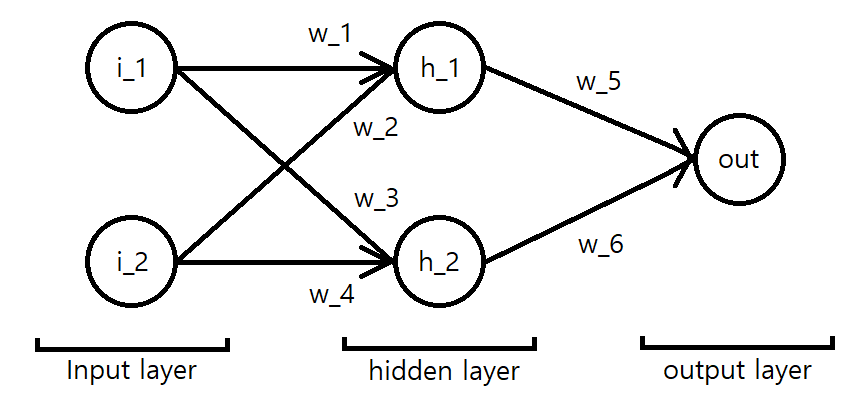

처럼 모델이 있을 때, 위 모델은

$$
h_1 = i_1 \cdot w_1 + i_2 \cdot w_2 \\
h_2 = i_1 \cdot w_3 + i_2 \cdot w_4 \\
out = h_1 \cdot w_5 + h_2 \cdot w_6
$$

$out$은 다시

$$
out = (i_1 \cdot w_1 + i_2 \cdot w_2) \cdot w_5 + (i_1 \cdot w_3 + i_2 \cdot w_4) \cdot w_6
$$

으로 쓸 수 있다.

이를 바탕으로 역전파를 진행하기 위한 각각 가중치에 대한 출력값의 변화량을 구한다.  
손실로 MSE를 사용한다면 출력층과 은닉층 사이의 가중치들은
<br><br>
$Loss = \frac{1}{2} (\text{prediction} - \text{real})^2$


$\frac{\partial \, Loss}{\partial \, w5} = \frac{\partial \, Loss}{\partial \, prediction} \cdot \frac{\partial \, prediction}{\partial \, w5}$

$\qquad\;\;\, = (\text{prediction} - \text{real}) \cdot \frac{\partial (h_1 \cdot w_5 + h_2 \cdot w_6)}{\partial \, w_5}$

$\qquad\;\;\, = \Delta \cdot h_1$
<br><br>
으로 이전 층 노드의 값으로 나타난다. 반면에 은닉층과 입력층 사이의 가중치 변화량을 구한다면.
<br><br>
$\frac{\partial \, Loss}{\partial \, w1} = \frac{\partial \, Loss}{\partial \, prediction} \cdot \frac{\partial \, prediction}{\partial \, h1} \cdot \frac{\partial \, h1}{\partial \, w1}$

$\qquad\;\;\, = (\text{prediction} - \text{real}) \cdot \frac{\partial (h_1 \cdot w_5 + h_2 \cdot w_6)}{\partial \, h_1} \cdot \frac{\partial (i_1 \cdot w_1 + i_2 \cdot w_2)}{\partial w_1}$

$\qquad\;\;\, = \Delta \cdot w_5 \cdot i_1$

위 식을 보면 다음 층의 가중치에 대한 손실의 변화량을 구하기 위해서 이전 층의 출력(여기서는 손실함수의 미분값이다) 현재 층의 가중치를 알아야한다. 

따라서 이 값들도 넘겨준다. 위 그림에서 보면 역전파 과정 중 이전 층 출력의 차원 크기는 (1), 가중치는 (3, 1)이다. 이를 dot product로 코드를 작성하면 다음과 같다.
```python
d_inputs = np.dot(dvalue, weights.T)
```

### A.4 ReLU

ReLU 함수는

$$
ReLU(x) = max(0, x)
$$

로 0 이상일 경우 입력값을 그대로 출력하고 아닐 경우에는 0을 반환하는 간단한 함수이다.  
이를 미분해주면 0을 기준으로 

$$
\frac{d \, ReLU(x)}{d \, x}=\begin{cases}
1, & \text{if $x>0$}.\\
0, & \text{otherwise}.
\end{cases}
$$

이다. 이를 다시 코드로 표현한다면
```python
z = 1 if x > 0 else 0 

# Numpy를 사용한다면
z = np.where(x>0, 1, 0)
```

## B. Modular

각 과정에 대한 설명은 모두 위에 작성되어있으므로 바로 모듈화를 진행한다.

In [43]:
%%writefile get_data.py
import os
import requests
from pathlib import Path

import pandas as pd

def download_data():
    """Download 'binary_dataset.csv' if this file not in data directory.
    If already have one, then skip downloading.
    This csv file contains 8 float type features and one binary target at last column.

    Return
        df (pandas.DataFrame): DataFrame with 9 columns. 
            First 8 columns (x1 ~ x8) are feature columns with float type.
            Last 1 column (y) is target column with binary type (0 or 1)
    """
    # 데이터 저장용 data 디렉토리 생용
    data_path = Path('data/')
    if not data_path.is_dir():
        data_path.mkdir(parents=True, exist_ok=True)

    try: # 데이터셋이 현재 위치에 있다면 판다스로 불러오기
        df = pd.read_csv(data_path / 'binary_dataset.csv') 
        # print("[INFO] 'binary_dataset.csv' already in directory. Get DataFrame from 'data/'")
    except: # 데이터셋이 현재 위치에 없다면
        with open(data_path / "binary_dataset.csv", "wb") as f: # requests로 url에서 데이터를 가져온 후에 판다스로 불러온다.
            request = requests.get("https://drive.google.com/uc?export=download&id=1SCO0ZGL_EDGWc9Le0JFDw9eww86xk1xJ")
            # print("[INFO] No 'binary_dataset.csv' found in current directory. Downloading dataset...")
            f.write(request.content)
            # print("[INFO] Download Done!")
        # !wget "https://drive.google.com/uc?export=download&id=1SCO0ZGL_EDGWc9Le0JFDw9eww86xk1xJ" -O "binary_dataset.csv"
        # !mv binary_dataset.csv {data_path}
        df = pd.read_csv(data_path / 'binary_dataset.csv')
    return df

Overwriting get_data.py


In [44]:
%%writefile data_setup.py

import numpy as np
import pandas as pd

# 배치 크기만큼 데이터를 넘겨주기 위해 데이터 로더 정의
class DataLoader:
    """Takes the Numpy array Dataset and return iterable data by the batch size.
    Args:
        df (numpy.array): Input Dataset to create iterable data.
            Last column must contain target data.
        batch_size (int): The number of samples to load on each batch.
        shuffle (bool): If 'shuffle=True', data reshuffled at every epoch.
    """
    def __init__(self,
                 df:pd.DataFrame,
                 batch_size:int=4,
                 shuffle:bool=False):
        self.data = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))

    def __len__(self):
        """Get length of DataLoader"""
        return (len(self.data)-1) // self.batch_size + 1

    def getitem(self):
        """Gernerate the iterable data by the batch size.
        Set `shuffle=True` when called the DataLoader makes data shuffles every epoch.
        
        Returns:
            X (list[list]): Features of dataset. shape: [batch_size, features]
            y (list): Target of dataset. shape: [batch_size]
        """
        if self.shuffle: # shuffle이 참이라면 인덱스를 섞어준다. 섞인 인덱스에 해당하는 데이터를 가져온다. 이로인해 에포크마다 배치의 데이터가 섞이게 된다.
            np.random.shuffle(self.indices) # 인덱스 섞기
        for i in range((len(self.data)-1)//self.batch_size + 1): # 데이터 수 / 배치사이즈 만큼 반복한다. 
            indices = self.indices[i*self.batch_size : (i+1)*self.batch_size] # 배치사이즈 만큼의 인덱스를 가져온다.
            X = self.data[indices, :-1] # 섞은 인덱스에 해당하는 값 중 타겟인 마지막 열의 데이터를 제외해서 가져온다.
            y = self.data[indices, -1].reshape(-1, 1) # 마찬가지로 타겟인 마지막 열의 데이터만 가져온다.
            yield X, y # 반복문이 사용 될 때 다음 배치를 가져올 수 있도록 generator로 만들어준다.

def train_test_split(data, train_split=0.8, shuffle=True):
    """Split the data into train and test dataset.
    `train_split` decide the training dataset size.
    Shuffle the dataset before split dataframe into training and test dataset if `shuffle=True`.

    Args:
        data (pandas.DataFrame): Target DataFrame to split.
        train_split (float): Percentage of training data. [0, 1]
        shuffle (bool): Set to True, dataset shuffled before splitting.

    Returns:
        train (np.array): Training Dataset. 
            Length of `train` is train_split times original dataframe length
        test (np.array): Test Dataset.
    """
    shuffled_index = np.random.permutation(len(data)) # 데이터 길이만큼 순서가 섞인 인덱스 배열을 만들어준다.
    split_index = int(train_split * len(data)) # 훈련 데이터 사이즈를 계산한다.

    train_indices = shuffled_index[:split_index] # 훈련 데이터 사이즈를 기준으로 섞은 인덱스 배열에서 훈련용 인덱스를 가져온다.
    test_indices = shuffled_index[split_index:] # 마찬가지로 테스트용 인덱스를 가져온다.

    data = data.to_numpy()
    train = data[train_indices] # 위에서 구한 훈련 인덱스에 해당하는 데이터를 훈련데이터로 지정한다.
    test = data[test_indices] # 테스트 인덱스의 데이터를 테스트 데이터로 지정한다.
    return train, test


class Standardizaion:
    """
    Standardize data along the feature axis.
    First use `fit` method to calculate mean and standard deviation of data.
    And use `transform` to get standardized data
    """
    def __init__(self):
        pass

    def fit(self, data):
        self.mean = data.mean(axis=0, keepdims=True)
        self.std = data.mean(axis=0, keepdims=True)

    def transform(self, data):
        return (data - self.mean) / self.std

Overwriting data_setup.py


In [45]:
%%writefile model_builder.py

import numpy as np

class Linear:
    """Apply linear transform. Create weights and biases, 
    which shapes are weight: [in_features, out_features], biases: [out_features]
    The weights are initialized to normal distribution multiplied by 0.1 and
    biases are uniform distribution, multiplied by 0.1.
    Args:
        in_features (int): The number of features at input
        out_features (int): The number of output features (number of neurons at output)
    """
    def __init__(self, 
                 in_features:int, 
                 out_features:int):
        self.weights = 0.1 * np.random.randn(in_features, out_features)
        self.biases = 0.1 * np.random.uniform(-1, 1, out_features)
        # self.biases = np.zeros(out_features)
    
    def forward(self, inputs):
        """Calculate linear transform along input data with weights and biases
        The equation of linear transform is $y = xA + b$"""
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.biases

    def backward(self, dvalues):
        """
        Calculate difference of `dvalues` by weights and biases. 
        The `dvalues` are output of before layer while back propagation
        """
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs
        

class ReLU:
    """
    Apply ReLU function.
    Forward method of ReLU object returns maximum value between 0 and input.
    """
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        return dvalues * np.where(self.output > 0, 1, 0)


class Sigmoid:
    """
    Apply Sigmoid function.
    Forward method of Sigmoid returns value between 0 and 1.
    If input much lager than 0, results will close to 1
    and lower than 0, then 0.
    """
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, dvalues):
        return dvalues * self.output * (1 - self.output)


class LinearModel:
    """Apply linear transform. 
    Between layers, apply ReLU activation function
    And apply sigmoid function to output of linear transform.
    
    Args:
        in_features (int): The number of features at input
        hidden_dim (int): The number of hidden layer's neuron.
        out_features (int): The number of output features (number of neurons at output)
    """
    def __init__(self,
                 in_features:int,
                 hidden_dim:int,
                 out_features:int):
        self.layers = [Linear(in_features=in_features,
                              out_features=hidden_dim),
                       ReLU(),
                       Linear(in_features=hidden_dim, # 입력층과 출력층 사이의 은닉층
                              out_features=hidden_dim),
                       ReLU(),
                       Linear(in_features=hidden_dim,
                              out_features=out_features),
                       Sigmoid()]

    def forward(self, x):
        for i in range(len(self.layers)): # Linear 객체를 가져오면서 그 Linear 층을 통과시킨다.
            temp = self.layers[i] 
            x = temp.forward(x)
        return x

    def backward(self, dvalues):
        for i in range(len(self.layers)-1, -1, -1):
            temp = self.layers[i]
            dvalues = temp.backward(dvalues)
        return dvalues

Overwriting model_builder.py


In [46]:
%%writefile train.py

import numpy as np
from data_setup import DataLoader
from model_builder import Linear

class BCELoss:
    """
    Calculate binary cross entropy loss.
    Set boundary of `pred` [1e-7, 1-1e-7] to prevent values get close to 0 in log.
    """

    def forward(self, true, pred):
        """
        Args:
            true: True label of dataset.
            pred: The output of the model. Contains the probability of prediction which is positive.
        """
        self.true = true
        self.pred = np.clip(pred, 1e-7, 1-1e-7)

        self.loss = -(self.true * np.log(self.pred) + (1-self.true) * np.log(1-self.pred))
        return self.loss

    def backward(self, dvalue):
        self.dvalue = np.clip(dvalue, 1e-7, 1-1e-7)
        return -(self.true / self.dvalue - (1 - self.true) / (1 - self.dvalue))


class SGD:
    """Stochastic Gradient Descent. Use learning rate and derivatives of layers,
    update parameters to minimize the loss. Learning rate determines how much of derivatives 
    effect the parameter changes.
    """
    def __init__(self,
                 lr=1e-3):
        self.lr = lr

    def zero_grad(self, model):
        for layer in model.layers[::-1]:
            if isinstance(layer, Linear):
                layer.dweights = 0
                layer.dbiases = 0

    def step(self, model):
        for layer in model.layers[::-1]:
            if isinstance(layer, Linear):
                layer.weights -= (self.lr * layer.dweights)
                layer.biases -= (self.lr * layer.dbiases)


def Accuracy(true: np.array,
             pred: np.array):
    """Calcuate Accuracy.
    Get true label and prediction probability, and round probability to compare with true which data type is integer.
    Args:
        true: True label of dataset.
        pred: The output of the model. Contains the probability of prediction which is positive.

    Returns: Accuracy
    """
    acc = sum(pred.round()==true)
    return acc[0]


def train_step(model,
               dataloader:DataLoader,
               loss_fn,
               optimizer,
               accuracy_fn):
    """
    Get data from DataLoader, run through training step which contains 
    (forward pass, loss calculation, optimzier initialize, back propagation, optimizer step).
    
    Args:
        model: Linear model to train.
        dataloader: Data generator, to be trained on model.
        loss_fn: Loss function to minimize.
        optimizer: Update parameters by using loss_fn and layers backward methods.
        accuracy_fn: Function to calculate accuracy.

    Returns:
        train_loss: Overall loss on one epoch using training data.
        train_acc: Overall accuracy on one epoch using training data.
    """
    train_loss, train_acc = 0, 0 # 훈련 결과 초기화

     # 훈련 데이터로더로 훈련 데이터 가져오기
    for X, y in dataloader.getitem():

        # 순전파를 통한 확률 예측
        y_pred_prob = model.forward(X)

        # 손실 계산
        loss = loss_fn.forward(y, y_pred_prob)

        # optimizer 초기화
        optimizer.zero_grad(model)

        # 손실함수 역전파
        dvalues = loss_fn.backward(y_pred_prob)
        # 모델 역전파
        model.backward(dvalues)

        # 모델 학습 가능한 파라미터 업데이트
        optimizer.step(model)

        # 배치사이즈 만큼 더해졌으므로 그만큼 나눠준다. 훈련 손실과 정확도 업데이트
        train_loss += loss.sum() / dataloader.batch_size
        train_acc += accuracy_fn(y, y_pred_prob) / dataloader.batch_size

    # 데이터로더의 길이만큼 더해졌으므로 그만큼 손실과 정확도를 나눠준다.
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(model,
              dataloader,
              loss_fn,
              accuracy_fn):
    """
    Get data from DataLoader, run through test step which contains (forward pass, loss calculation). 
    Unlike training step, test step doesn't have optimizer step and back propagation.

    Args:
        model: Linear model to be tested.
        dataloader: Data generator, to be tested on model.
        loss_fn: Loss function to minimize.
        accuracy_fn: Function to calculate accuracy.

    Returns:
        train_loss: Overall loss on one epoch using test data.
        train_acc: Overall accuracy on one epoch using test data.
    """
    test_loss, test_acc = 0, 0 # 테스트 결과 초기화

    # 테스트 데이터로더로 테스트 데이터 가져오기
    for X_test, y_test in dataloader.getitem():

        # 순전파를 통한 예측 진행
        test_pred_prob = model.forward(X_test)

        # 손실 계산 
        loss = loss_fn.forward(y_test, test_pred_prob)

        # 훈련 과정과 똑같이 테스트 손실과 정확도 업데이트
        test_loss += loss.sum() / dataloader.batch_size
        test_acc += accuracy_fn(y_test, test_pred_prob) / dataloader.batch_size
            
    # 훈련 과정과 똑같이 테스트 손실과 정확도 업데이트
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

def train(model,
          train_dataloader,
          test_dataloader,
          loss_fn,
          optimizer,
          accuracy_fn,
          epochs):
    """
    Pass model through train_step() and test_step(), repeat as many as epochs.
    
    Args:
        model: Linear model to train and to be tested.
        train_dataloader: Dataloader used in train step.
        test_dataloader: Dataloader usesd in test step.
        loss_fn: Loss function to minimize.
        optimizer: Update trainable parameters.
        accuracy_fn: Function to calculate accuracy.
        epochs: How many times training loop repeat.

    Returns:
        results (Dict[str, List]): Results of training step and test step. 
            Loss value and Accuracy for each step for epochs.
    """
    # 결과 초기화
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
   
    # 에포크마다 반복
    for epoch in range(epochs):
        # 훈련 과정을 진행하고 손실과 정확도 계산
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn)
        # 테스트 과정을 진행하고 손실과 정확도 계산
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        
        # 결과 딕셔너리에 훈련과 테스트 결과(손실, 정확도) 저장
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        # 결과 출력
        if (epoch % (epochs//10) == 0) or (epoch == epochs-1):
            print(f"[Epochs {epoch+1}/{epochs}] | "
                f"Train Loss: {train_loss:.4f} | "
                f"Train Accuracy: {train_acc:.4f} | "
                f"Test Loss: {test_loss:.4f} | "
                f"Test Accuracy: {test_acc:.4f}")
        
    return results

Overwriting train.py


In [47]:
%%writefile utils.py

import pickle
from pathlib import Path

def save_model(model,
               model_name,
               save_dir):
    """
    Save model by pickle file to save_dir for model reusablity.

    Args: 
        model: Target model to save.
        model_name: Target name model will be saved.
            model_name should ends with 'pickle'
        save_dir: Target directory where model to saved.
    """
    save_dir = Path(save_dir)
    if not save_dir.is_dir():
        save_dir.mkdir(exist_ok=True, parents=True)

    assert model_name.endswith('.pickle'), "model_name should ends with '.pickle'"

    with open(save_dir / model_name, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model file saved in {save_dir/model_name}")

def load_model(model_name,
               saved_dir):
    """
    Load model from saved directory.

    Args:
        model_name: Model name to load from directory.
            Model name should ends with 'pickle'
        saved_dir: Directory where the saved model is in.

    Returns:
        model: 
    """
    saved_dir = Path(saved_dir)

    assert model_name.endswith('.pickle'), "model_name should ends with '.pickle'"

    with open(saved_dir / model_name, 'rb') as f:
        model = pickle.load(f)

    print(f"Model successsfully loaded!")
    return model

Overwriting utils.py


In [48]:
%%writefile main.py
"""
Train binary classification model.
"""

import get_data, data_setup, model_builder, train, utils


# 하이퍼 파라미터 지정
EPOCHS = 500
BATCH_SIZE = 4

MODEL_DIR = 'model'
MODEL_NAME = 'binary_classifier.pickle'

hidden_dim = 20
out_features = 1

# 데이터 불러오기
binary_df = get_data.download_data()

# 훈련, 테스트 데이터 분리 + 섞기
train_df, test_df = data_setup.train_test_split(binary_df)

# 데이터 표준화
std_scaler = data_setup.Standardizaion()
std_scaler.fit(train_df[:, :-1])
train_df[:, :-1] = std_scaler.transform(train_df[:, :-1])
test_df[:, :-1] = std_scaler.transform(test_df[:, :-1])

# 배치 사이즈만큼 데이터를 넘겨주는 훈련, 테스트 데이터로더 객체 생성
train_dataloader = data_setup.DataLoader(train_df, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_dataloader = data_setup.DataLoader(test_df,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

# 모델 생성
model = model_builder.LinearModel(in_features=binary_df.shape[1]-1,
                                  hidden_dim=hidden_dim,
                                  out_features=out_features)

# 손실 함수 정의
loss_fn = train.BCELoss()
# optimizer 정의
optimizer = train.SGD(lr=0.001)
# 정확도 계산 함수 정의
accuracy_fn = train.Accuracy

# 훈련 과정 진행
results = train.train(model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     accuracy_fn=accuracy_fn,
                     epochs=EPOCHS)

utils.save_model(model, MODEL_NAME, MODEL_DIR)

Overwriting main.py


In [49]:
!python main.py

[Epochs 1/500] | Train Loss: 0.6784 | Train Accuracy: 0.6250 | Test Loss: 0.6346 | Test Accuracy: 1.0000
[Epochs 51/500] | Train Loss: 0.6656 | Train Accuracy: 0.6250 | Test Loss: 0.5946 | Test Accuracy: 1.0000
[Epochs 101/500] | Train Loss: 0.6528 | Train Accuracy: 0.6250 | Test Loss: 0.5600 | Test Accuracy: 1.0000
[Epochs 151/500] | Train Loss: 0.6374 | Train Accuracy: 0.6250 | Test Loss: 0.5279 | Test Accuracy: 1.0000
[Epochs 201/500] | Train Loss: 0.6143 | Train Accuracy: 0.7500 | Test Loss: 0.4919 | Test Accuracy: 1.0000
[Epochs 251/500] | Train Loss: 0.5769 | Train Accuracy: 0.7500 | Test Loss: 0.4469 | Test Accuracy: 1.0000
[Epochs 301/500] | Train Loss: 0.5286 | Train Accuracy: 0.7500 | Test Loss: 0.3923 | Test Accuracy: 1.0000
[Epochs 351/500] | Train Loss: 0.4861 | Train Accuracy: 0.7500 | Test Loss: 0.3433 | Test Accuracy: 1.0000
[Epochs 401/500] | Train Loss: 0.4558 | Train Accuracy: 0.8125 | Test Loss: 0.3077 | Test Accuracy: 1.0000
[Epochs 451/500] | Train Loss: 0.4354 | 